In [2]:
#pip install prophet


In [4]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsaplots
from sklearn.model_selection import train_test_split
from copy import deepcopy #helper to copy list objects...
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima # This library is to find automatically the best PDQ parameters 
from prophet import Prophet
import warnings #simplify alerts

warnings.simplefilter(action='ignore')

<h1> Weather Data </h1>
<p> This API pulls Weather Data by day </p>

In [8]:
import urllib.request
import sys
import json
                
try: 
  #ResultBytes = urllib.request.urlopen("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/4401%204th%20Ave%20S%2C%20Seattle%2C%20WA%2098134/2023-11-06/2023-11-13?unitGroup=us&include=days&key=ENTERKEYHERE&contentType=json")
  ResultBytes = urllib.request.urlopen("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/4401%204th%20Ave%20S%2C%20Seattle%2C%20WA%2098134/2018-06-29/2018-06-30?unitGroup=us&include=days&key=ENTERKEYHERE&contentType=json")

  # Parse the results as JSON
  jsonData = json.load(ResultBytes)
          
except urllib.error.HTTPError  as e:
  ErrorInfo= e.read().decode() 
  print('Error code: ', e.code, ErrorInfo)
  sys.exit()
except  urllib.error.URLError as e:
  ErrorInfo= e.read().decode() 
  print('Error code: ', e.code,ErrorInfo)
  sys.exit()



In [9]:
# Extracting data from the 'days' key
weather_data = jsonData['days']

df_weather = pd.DataFrame(weather_data)

# Extracting the day of the week from the 'datetime' column
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather['day_of_week'] = df_weather['datetime'].dt.day_name()

# Pivot the DataFrame to have days as columns
df_weather_pivoted = df_weather.pivot_table(index='datetime', columns='day_of_week', values=['feelslike', 'precip','snow','sunset'])

# Flatten the multi-level column index
df_weather_pivoted.columns = [f"{col[0]}_{col[1]}" for col in df_weather_pivoted.columns]

# Reset the index to have 'datetime' as a column
df_weather_pivoted.reset_index(inplace=True)

df_weather_pivoted

,datetime,feelslike_Friday,feelslike_Saturday,precip_Friday,precip_Saturday,snow_Friday,snow_Saturday
0,2018-06-29,63.9,NaN,0.0,NaN,0.0,NaN
1,2018-06-30,NaN,62.1,NaN,0.012,NaN,0.0


In [10]:
csv_filename = 'SeattleWeather.csv'
df_weather.to_csv(csv_filename, index=False)



In [11]:
# This section is temporary to read from a CSV when the file is not present 
df_weather=pd.read_csv('SeattleWeatherDB.csv')
# Pivot the DataFrame to have days as columns


df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather['day_of_week'] = df_weather['datetime'].dt.day_name()



df_weather_pivoted = df_weather.pivot_table(index='datetime', columns='day_of_week', values=['feelslike', 'precip','snow','sunset'])

# Flatten the multi-level column index
df_weather_pivoted.columns = [f"{col[0]}_{col[1]}" for col in df_weather_pivoted.columns]

# Reset the index to have 'datetime' as a column
df_weather_pivoted.reset_index(inplace=True)

df_weather_pivoted
df_weather.head()

,datetime,datetimeEpoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,sunsetEpoch,moonphase,conditions,description,icon,stations,source,tzoffset,severerisk,day_of_week
0,2018-07-01,1530428400,69.4,57.0,61.7,69.4,57.0,61.7,51.9,71.4,...,1530504615,0.62,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"['72793024233', 'KSEA', 'KBFI', 'E8046', '7279...",obs,NaN,Sunday,Sunday
1,2018-07-02,1530514800,69.0,54.1,61.3,69.0,54.1,61.3,45.3,57.2,...,1530590999,0.65,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['E7103', '72793024233', 'KSEA', 'KBFI', 'E804...",obs,NaN,Monday,Monday
2,2018-07-03,1530601200,73.5,51.1,62.9,73.5,51.1,62.9,46.1,57.1,...,1530677380,0.69,Clear,Clear conditions throughout the day.,clear-day,"['E7103', '72793024233', 'KSEA', 'KBFI', '7279...",obs,NaN,Tuesday,Tuesday
3,2018-07-04,1530687600,79.9,57.8,68.6,79.9,57.8,68.6,51.1,54.6,...,1530763759,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['E7103', '72793024233', 'KSEA', 'KBFI', 'E804...",obs,NaN,Wednesday,Wednesday
4,2018-07-05,1530774000,84.0,60.3,71.4,82.6,60.3,71.2,52.8,54.5,...,1530850135,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"['72793024233', 'KSEA', 'KBFI', 'E8046', '7279...",obs,NaN,Thursday,Thursday


In [75]:
df_weather_pivoted['WeekStart'] = df_weather_pivoted['datetime'] - pd.to_timedelta(df_weather_pivoted['datetime'].dt.dayofweek, unit='D')
df_weather_pivoted['WeekEnd'] = df_weather_pivoted['WeekStart'] + pd.DateOffset(days=6)
df_weather_pivoted.head()

df_weather_grp = df_weather_pivoted.groupby(['WeekEnd'], as_index=False).agg({'feelslike_Monday': 'sum','feelslike_Tuesday': 'sum','feelslike_Wednesday': 'sum','feelslike_Thursday': 'sum','feelslike_Friday': 'sum','feelslike_Saturday': 'sum','feelslike_Sunday': 'sum'})
# Display the resulting grouped DataFrame

#Using the average of the week
df_weather_grp['avgtemp']=(df_weather_grp['feelslike_Monday']+df_weather_grp['feelslike_Tuesday']+df_weather_grp['feelslike_Wednesday']+df_weather_grp['feelslike_Thursday']+df_weather_grp['feelslike_Friday']+df_weather_grp['feelslike_Saturday']+df_weather_grp['feelslike_Sunday'])/7

columns_to_drop = [
    'feelslike_Monday', 'feelslike_Tuesday', 'feelslike_Wednesday',
    'feelslike_Thursday', 'feelslike_Friday', 'feelslike_Saturday', 'feelslike_Sunday'
]

df_weather_grp.drop(columns=columns_to_drop, inplace=True)
df_weather_grp.head()


,WeekEnd,avgtemp
0,2018-07-01,8.814286
1,2018-07-08,66.928571
2,2018-07-15,70.685714
3,2018-07-22,68.828571
4,2018-07-29,74.285714


<h1> Other Indicators To Consider </h1>
<p> Forward Indicators: Cardboard Consumption, Shipments, trucking activity, refer rates, median income, cost of life, % from home, Schools graduations... bankrupcies... GDP, CPI; Costco stocks, financial performace, employment</p>

<h4> https://www.dat.com/trendlines/van/demand-and-capacity </hs>

<h1> Gas Prices From API DF </h1>
<p> The following API pull the weekly gas prices for the US to be used as Exogenous variables  </p>


In [76]:
import requests

# API endpoint
# For Seattle Y48SE
# For CA SCA "https://api.eia.gov/v2/petroleum/pri/gnd/data/?frequency=weekly&data[0]=value&facets[product][]=EPMR&facets[duoarea][]=SCA&start=2008-01-01&offset=0&length=50000&api_key=ENTERKEYHERE"

url = "https://api.eia.gov/v2/petroleum/pri/gnd/data/?frequency=weekly&data[0]=value&facets[product][]=EPMR&facets[duoarea][]=Y48SE&start=2008-01-01&offset=0&length=50000&api_key=ENTERKEYHERE"

# Make a GET request to the API
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Load the JSON response data
    json_object = response.json()

    data =json_object['response']['data']
    df_gas = pd.DataFrame(data)
    
else:
    print("Failed to retrieve data. Status code:", response.status_code)

df_gas.head()


,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2008-01-07,Y48SE,SEATTLE,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_Y48SE_DPG,"Seattle, WA Regular All Formulations Retail Ga...",3.189,$/GAL
1,2008-03-10,Y48SE,SEATTLE,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_Y48SE_DPG,"Seattle, WA Regular All Formulations Retail Ga...",3.475,$/GAL
2,2008-06-09,Y48SE,SEATTLE,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_Y48SE_DPG,"Seattle, WA Regular All Formulations Retail Ga...",4.240,$/GAL
3,2008-09-29,Y48SE,SEATTLE,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_Y48SE_DPG,"Seattle, WA Regular All Formulations Retail Ga...",3.650,$/GAL
4,2008-10-06,Y48SE,SEATTLE,EPMR,Regular Gasoline,PTE,Retail Sales,EMM_EPMR_PTE_Y48SE_DPG,"Seattle, WA Regular All Formulations Retail Ga...",3.543,$/GAL


In [77]:
# Convert 'period' column to datetime type
df_gas['period'] = pd.to_datetime(df_gas['period'])

# Add 7 days to each date in 'period' column
df_gas['WeekEnd'] = df_gas['period'] + pd.DateOffset(days=6)


df_gas=df_gas.drop(['period','duoarea','area-name','product','product-name','process','process-name','series','series-description','units'],axis=1)
df_gas =df_gas.rename(columns={'value': 'GasValue'})

df_gas.head()

,GasValue,WeekEnd
0,3.189,2008-01-13
1,3.475,2008-03-16
2,4.240,2008-06-15
3,3.650,2008-10-05
4,3.543,2008-10-12


<h1> POS Sales information By Store Category Day </h1>

In [78]:
# Connection Settings
server = 'EnterServer'
database = 'WarehouseManagement'
username = 'USername'
password = 'Password'

# Connection string for SQL Server using pyodbc
conn_str = f'Driver={{SQL Server}};Server={server};Database={database};UID={username};PWD={password}'

# Establish a SQLAlchemy connection
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={conn_str}")

# SQL query to select data from your table
query = "select [Facility] ,[Store] ,[DateSold], case when CategoryItemCode in ('T1','XW','E1') then 'CV' when CategoryItemCode in ('VR','RV') then 'RB' else CategoryItemCode end as CategoryItemCode  ,[QuantitySold] , cast(CEILING(((AmountSold/QuantitySold)/.905) / 10) * 10 as float) - 0.01 AS RoundedRetailPrice FROM [WarehouseManagement].[dbo].[Qry_WF_CCO_EDI_Daily_Sales] where QuantitySold>0 and DateSold <= dateadd(dd,-7,DATEADD(DAY, 6 - DATEPART(WEEKDAY, GETDATE()), CONVERT(DATE, GETDATE()))) and CategoryItemCode<>'FR' and Facility='KDN' and store in('Costco - 00001 - Seattle','Costco - 00747 - Woodinville') and CategoryItemCode in('GB','MB','RB') "  

# Import data into a pandas DataFrame using SQLAlchemy
df_sls = pd.read_sql(query, engine)

# Display the DataFrame
df_sls.head()


,Facility,Store,DateSold,CategoryItemCode,QuantitySold,RoundedRetailPrice
0,KDN,Costco - 00001 - Seattle,2008-08-01,MB,39.0,19.99
1,KDN,Costco - 00001 - Seattle,2008-08-02,MB,29.0,19.99
2,KDN,Costco - 00001 - Seattle,2008-08-03,MB,18.0,19.99
3,KDN,Costco - 00001 - Seattle,2008-08-04,MB,18.0,19.99
4,KDN,Costco - 00001 - Seattle,2008-08-05,MB,12.0,19.99


In [79]:
df_sls['WeekStart'] = df_sls['DateSold'] - pd.to_timedelta(df_sls['DateSold'].dt.dayofweek, unit='D')
df_sls['WeekEnd'] = df_sls['WeekStart'] + pd.DateOffset(days=6)
df_sls.head()

,Facility,Store,DateSold,CategoryItemCode,QuantitySold,RoundedRetailPrice,WeekStart,WeekEnd
0,KDN,Costco - 00001 - Seattle,2008-08-01,MB,39.0,19.99,2008-07-28,2008-08-03
1,KDN,Costco - 00001 - Seattle,2008-08-02,MB,29.0,19.99,2008-07-28,2008-08-03
2,KDN,Costco - 00001 - Seattle,2008-08-03,MB,18.0,19.99,2008-07-28,2008-08-03
3,KDN,Costco - 00001 - Seattle,2008-08-04,MB,18.0,19.99,2008-08-04,2008-08-10
4,KDN,Costco - 00001 - Seattle,2008-08-05,MB,12.0,19.99,2008-08-04,2008-08-10


In [80]:
df_sls['DateSold'].min()

Timestamp('2008-06-03 00:00:00')

In [81]:
# Grouping Sales by Week
df_sls_grp = df_sls.groupby(['Facility', 'Store', 'CategoryItemCode', 'RoundedRetailPrice','WeekEnd'], as_index=False).agg({'QuantitySold': 'sum'})
df_sls_grp.head()

,Facility,Store,CategoryItemCode,RoundedRetailPrice,WeekEnd,QuantitySold
0,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-08,331.0
1,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-15,507.0
2,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-22,352.0
3,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-29,313.0
4,KDN,Costco - 00001 - Seattle,GB,9.99,2008-07-06,259.0


<h1> Calendar Information </h1>

In [129]:
# Connection Settings
server = 'Server'
database = 'WarehouseManagement'
username = 'UserName'
password = 'Password'

# Connection string for SQL Server using pyodbc
conn_str = f'Driver={{SQL Server}};Server={server};Database={database};UID={username};PWD={password}'

# Establish a SQLAlchemy connection
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={conn_str}")

# SQL query to select data from your table
query = "select * FROM [WarehouseManagement].[dbo].[Calendar_Holiday] where RampUpDays>1"

# Import data into a pandas DataFrame using SQLAlchemy
df_events_And_Holidays = pd.read_sql(query, engine)


#Add WeekEndings
df_events_And_Holidays['WeekStart'] = df_events_And_Holidays['Date'] - pd.to_timedelta(df_events_And_Holidays['Date'].dt.dayofweek, unit='D')
df_events_And_Holidays['WeekEnd'] = df_events_And_Holidays['WeekStart'] + pd.DateOffset(days=6)

# Display the DataFrame
df_events_And_Holidays.head()

,Year,Date,Holiday Name,RampUpDays,WeekStart,WeekEnd
0,2007.0,2007-02-14,Valentine's Day,7.0,2007-02-12,2007-02-18
1,2007.0,2007-02-18,Chinesse NY,2.0,2007-02-12,2007-02-18
2,2007.0,2007-04-08,Easter Sunday,4.0,2007-04-02,2007-04-08
3,2007.0,2007-05-10,Mexicans Mothers Day,3.0,2007-05-07,2007-05-13
4,2007.0,2007-05-13,Mother's Day,7.0,2007-05-07,2007-05-13


<p> Creting Holiday Dataframe for prophet </p>

In [130]:
df_prophet_holidays=df_events_And_Holidays[['WeekEnd','Holiday Name','RampUpDays']].rename(columns={'WeekEnd': 'ds'}).rename(columns={'Holiday Name': 'holiday'}).rename(columns={'RampUpDays': 'lower_window'})
df_prophet_holidays['upper_window']=0 #Include this into the holiday table
df_prophet_holidays['lower_window']=df_prophet_holidays['lower_window']*-1
df_prophet_holidays

,ds,holiday,lower_window,upper_window
0,2007-02-18,Valentine's Day,-7.0,0
1,2007-02-18,Chinesse NY,-2.0,0
2,2007-04-08,Easter Sunday,-4.0,0
3,2007-05-13,Mexicans Mothers Day,-3.0,0
4,2007-05-13,Mother's Day,-7.0,0
...,...,...,...,...
305,2019-08-25,MBPromo,-21.0,0
306,2020-08-30,MBPromo,-21.0,0
307,2021-08-29,MBPromo,-14.0,0
308,2022-08-28,MBPromo,-21.0,0


In [131]:
# This section is designed to provide ramp up days for Sarimax to Handle the whole holiday period

# Create a new DataFrame to store expanded holiday dates
df_expanded_holidays = pd.DataFrame(columns=['Year', 'Date', 'Holiday Name', 'RampUpDays'])


# Iterate over each row in the original DataFrame
for index, row in df_events_And_Holidays.iterrows():
    holiday_date = row['Date']
    ramp_up_days = int(row['RampUpDays'])

    # Generate a range of dates for the ramp-up period
    ramp_up_dates = pd.date_range(end=holiday_date, periods=ramp_up_days + 1, freq='D')

    # Add the generated dates to the new DataFrame
    expanded_rows = pd.DataFrame({
        'Year': row['Year'],
        'Date': ramp_up_dates[:-1],  # Exclude the holiday date itself
        'Holiday Name': row['Holiday Name'],
        'RampUpDays': range(ramp_up_days, 0, -1)  # Reverse ramp-up days
    })

    df_expanded_holidays = pd.concat([df_expanded_holidays, expanded_rows], ignore_index=True)

# Sort the new DataFrame by 'Year' and 'Date'
df_expanded_holidays.sort_values(by=['Year', 'Date'], inplace=True)


#Add WeekEndings
df_expanded_holidays['WeekStart'] = df_expanded_holidays['Date'] - pd.to_timedelta(df_expanded_holidays['Date'].dt.dayofweek, unit='D')
df_expanded_holidays['WeekEnd'] = df_expanded_holidays['WeekStart'] + pd.DateOffset(days=6)


# Display the result
df_expanded_holidays


,Year,Date,Holiday Name,RampUpDays,WeekStart,WeekEnd
0,2007.0,2007-02-07,Valentine's Day,7,2007-02-05,2007-02-11
1,2007.0,2007-02-08,Valentine's Day,6,2007-02-05,2007-02-11
2,2007.0,2007-02-09,Valentine's Day,5,2007-02-05,2007-02-11
3,2007.0,2007-02-10,Valentine's Day,4,2007-02-05,2007-02-11
4,2007.0,2007-02-11,Valentine's Day,3,2007-02-05,2007-02-11
...,...,...,...,...,...,...
1127,2040.0,2040-12-19,Christmas Eve,5,2040-12-17,2040-12-23
1128,2040.0,2040-12-20,Christmas Eve,4,2040-12-17,2040-12-23
1129,2040.0,2040-12-21,Christmas Eve,3,2040-12-17,2040-12-23
1130,2040.0,2040-12-22,Christmas Eve,2,2040-12-17,2040-12-23


<p> To handle duplicates each holiday get placed as a binary, need to work on understanding how to give weight to each of the weeks. or maybe forecast by day instead of week. </p>

In [132]:


# Create binary indicators for each holiday
events = pd.get_dummies(df_expanded_holidays['Holiday Name'], prefix='Evt')

# Concatenate the binary indicators with the original DataFrame
df_expanded_holidays = pd.concat([df_expanded_holidays, events], axis=1)

# Group by 'WeekEnd' and aggregate the binary indicators
df_events_grp= df_expanded_holidays.groupby('WeekEnd').agg({col: 'sum' for col in events.columns})

# Reset the index to make 'WeekEnd' a column again
df_events_grp = df_events_grp.reset_index()

#Saving the file to check in Excel
csv_filename = 'df_events_grp.csv'
df_events_grp.to_csv(csv_filename, index=False)

# Display the resulting DataFrame
df_events_grp.head()

,WeekEnd,Evt_Chinesse NY,Evt_Christmas Eve,Evt_Easter Sunday,Evt_GBPromo,Evt_Guadalupe,Evt_MBPromo,Evt_Mexicans Mothers Day,Evt_Mother's Day,Evt_RBPromo,Evt_Thanksgiving Day,Evt_Valentine's Day
0,2007-02-11,0,0,0,0,0,0,0,0,0,0,5
1,2007-02-18,2,0,0,0,0,0,0,0,0,0,2
2,2007-04-08,0,0,4,0,0,0,0,0,0,0,0
3,2007-05-06,0,0,0,0,0,0,0,1,0,0,0
4,2007-05-13,0,0,0,0,0,0,3,6,0,0,0


<h1> Merging all Dataframes </h1>

In [133]:
#Merging Exogenous with Time Series Data
df_model = pd.merge(df_sls_grp, df_gas,  on='WeekEnd', how='left')
df_model = pd.merge(df_model, df_weather_grp,  on='WeekEnd', how='left')
df_model = pd.merge(df_model, df_events_grp,  on='WeekEnd', how='left')

df_model.head()

,Facility,Store,CategoryItemCode,RoundedRetailPrice,WeekEnd,QuantitySold,GasValue,avgtemp,Evt_Chinesse NY,Evt_Christmas Eve,Evt_Easter Sunday,Evt_GBPromo,Evt_Guadalupe,Evt_MBPromo,Evt_Mexicans Mothers Day,Evt_Mother's Day,Evt_RBPromo,Evt_Thanksgiving Day,Evt_Valentine's Day
0,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-08,331.0,4.139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-15,507.0,4.240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-22,352.0,4.336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KDN,Costco - 00001 - Seattle,GB,9.99,2008-06-29,313.0,4.355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KDN,Costco - 00001 - Seattle,GB,9.99,2008-07-06,259.0,4.355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h1>MODELS </h1>

<h4> Defining Train, Test Date Splits </h4>
<p> Pending to add code to limit range dinamically depending on the store being fit, this might have to go inside the store loop Also we need to match gas prices by region and weather at the store level for now </p>

In [134]:
#Identify the maximum weekend date
MAX_WEEK_END =min(df_weather_pivoted['WeekEnd'].max(),df_model ['WeekEnd'].max())
#Calculate the maximum training date as X weeks prior to the maximum weekend date
MAX_TRAINING_DT = MAX_WEEK_END  - pd.Timedelta(weeks=12)

# With full API this weather needs to be moved into the store loop or load it store by store...
MIN_WEEK_END=df_weather_pivoted['WeekEnd'].min()
print("MIN_WEEK_END",MIN_WEEK_END)
#Remove this as soon as all data is gathered.
df_model=df_model.fillna(0)
df_model=df_model[df_model['WeekEnd']>=MIN_WEEK_END]
df_model=df_model[df_model['WeekEnd']<=MAX_WEEK_END ]
print("MAX_TRAINING_DT", MAX_TRAINING_DT)
print("MAX_WEEK_END",MAX_WEEK_END)
print('Starting Data Pint',df_model['WeekEnd'].min())

MIN_WEEK_END 2018-07-01 00:00:00
MAX_TRAINING_DT 2023-08-20 00:00:00
MAX_WEEK_END 2023-11-12 00:00:00
Starting Data Pint 2018-07-01 00:00:00


<h4> Sarimax & Profet by store/Category </h4>
<p> Understand if weeks need to be shifted as a good practice or just the events varaibles, can handle it. understand if total tred of all stores is helpful or not, understand if forecasting by day rather than week is better </p>

Store Costco - 00001 - Seattle - Category GB Forecast


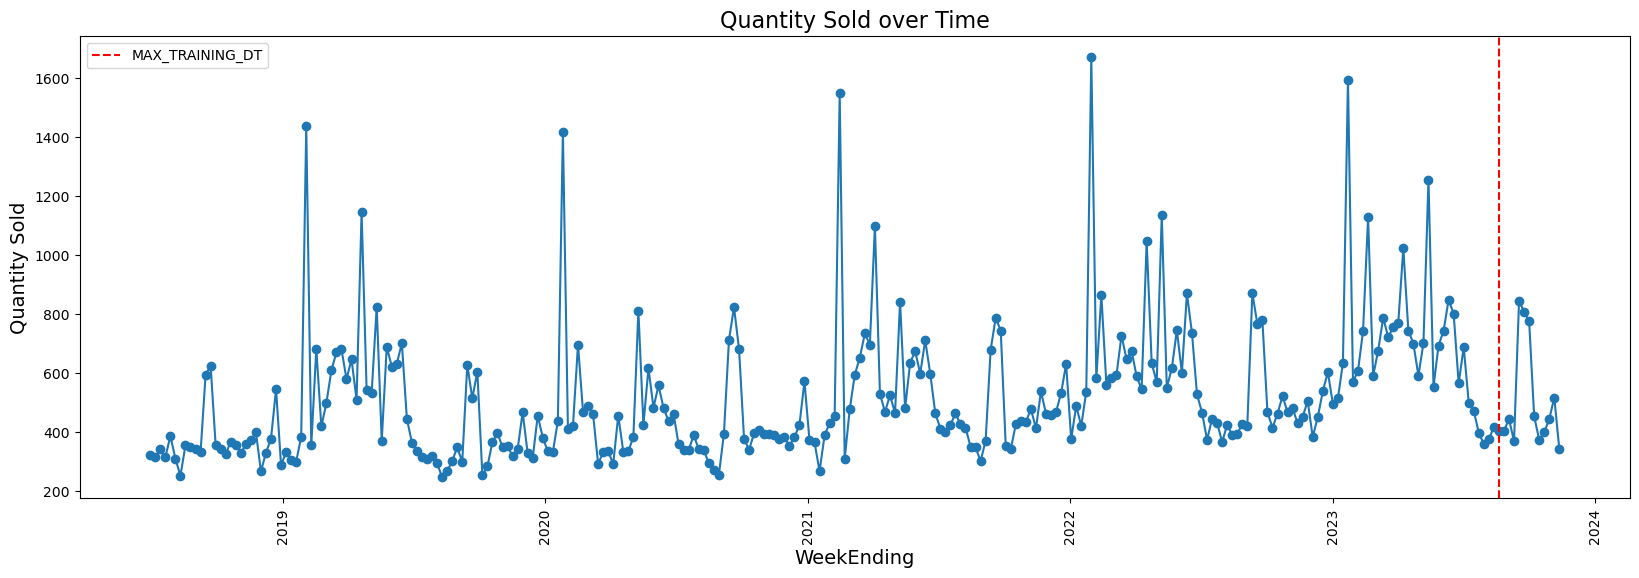

AutoCorrelations


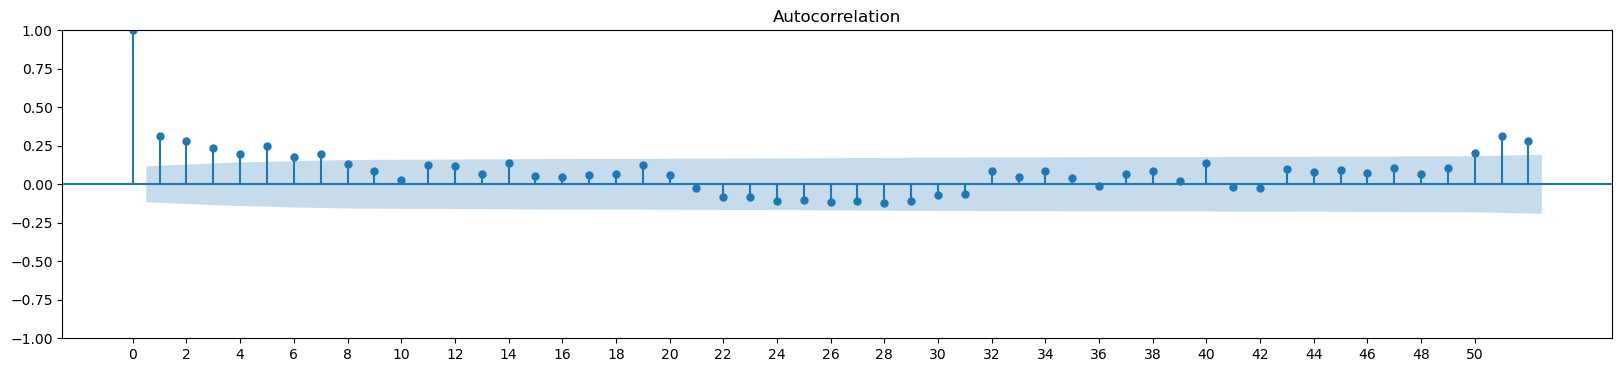

Understanding if the diff is stationaty


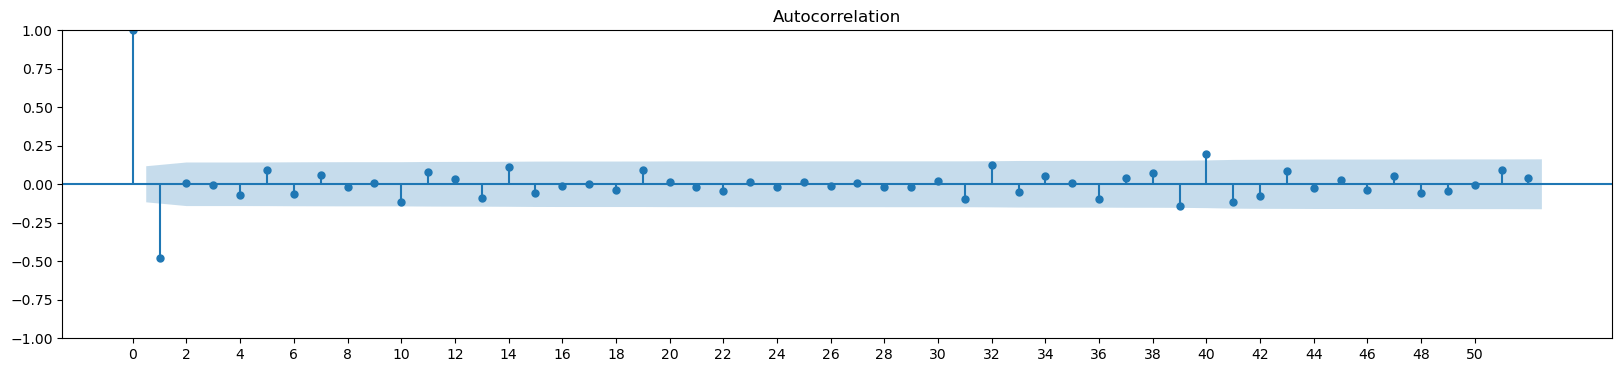

Selected Order (p, d, q): (1, 1, 4)
Selected Seasonal Order (P, D, Q, s): (1, 1, 0, 52)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  268
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 52)   Log Likelihood               -1353.209
Date:                             Tue, 14 Nov 2023   AIC                           2748.418
Time:                                     19:48:40   BIC                           2819.202
Sample:                                 07-01-2018   HQIC                          2777.018
                                      - 08-13-2023                                         
Covariance Type:                               opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

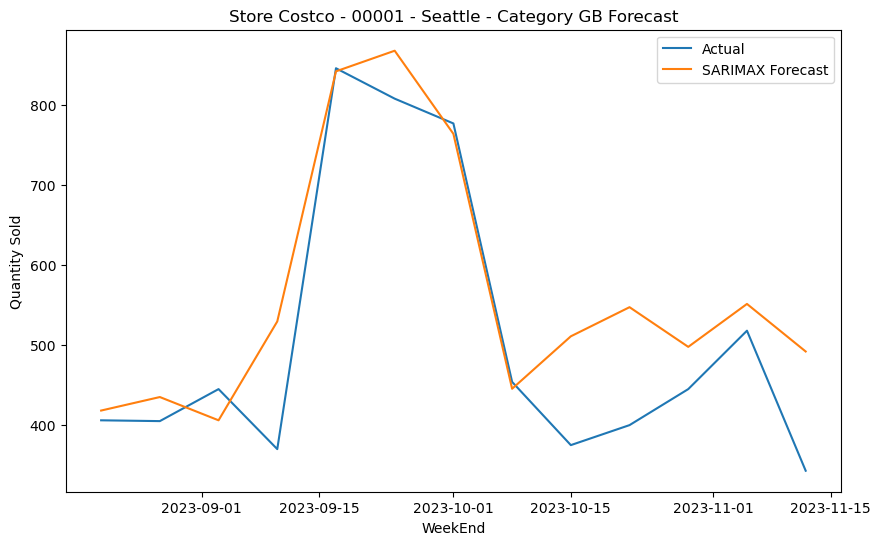

Training Set


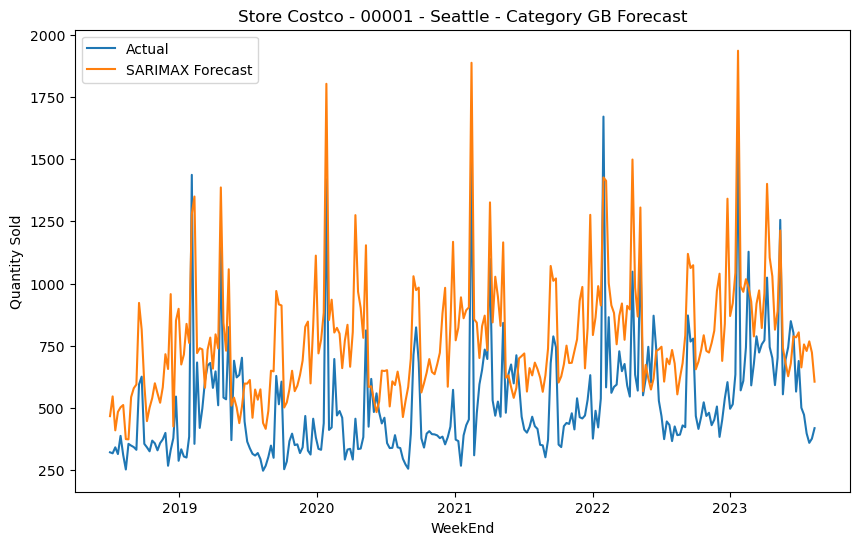

-----------------------------PROPHET RESULTS--------------------------------------


19:48:40 - cmdstanpy - INFO - Chain [1] start processing
19:48:40 - cmdstanpy - INFO - Chain [1] done processing


Store Costco - 00001 - Seattle - Category MB Forecast


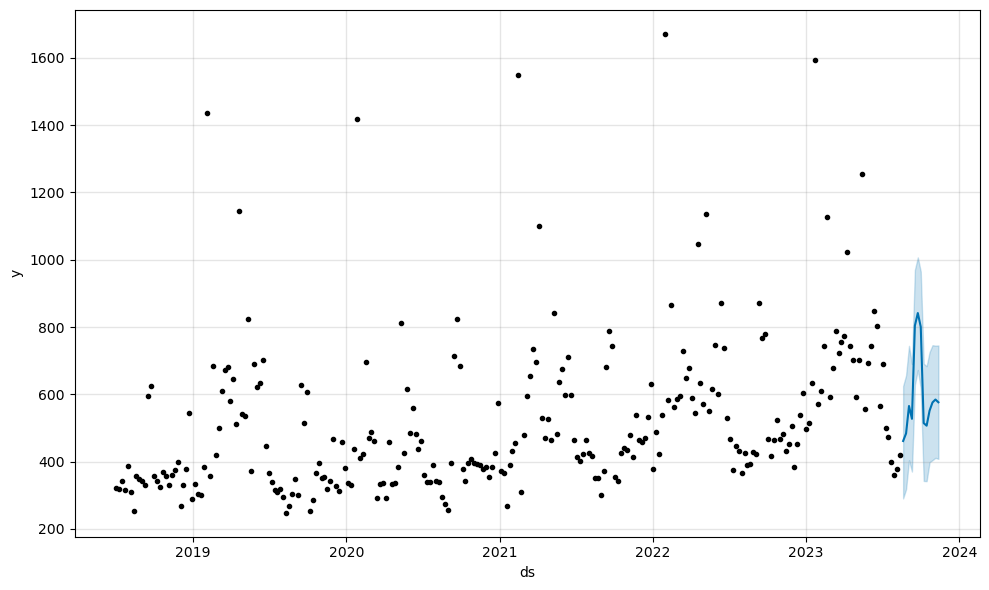

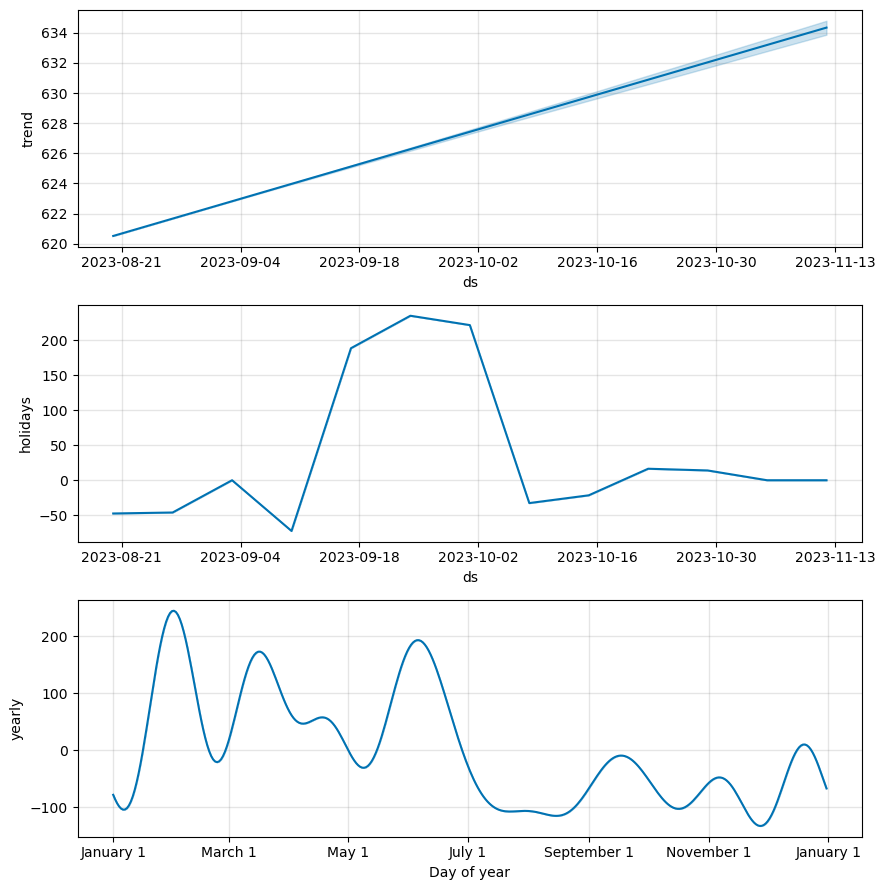

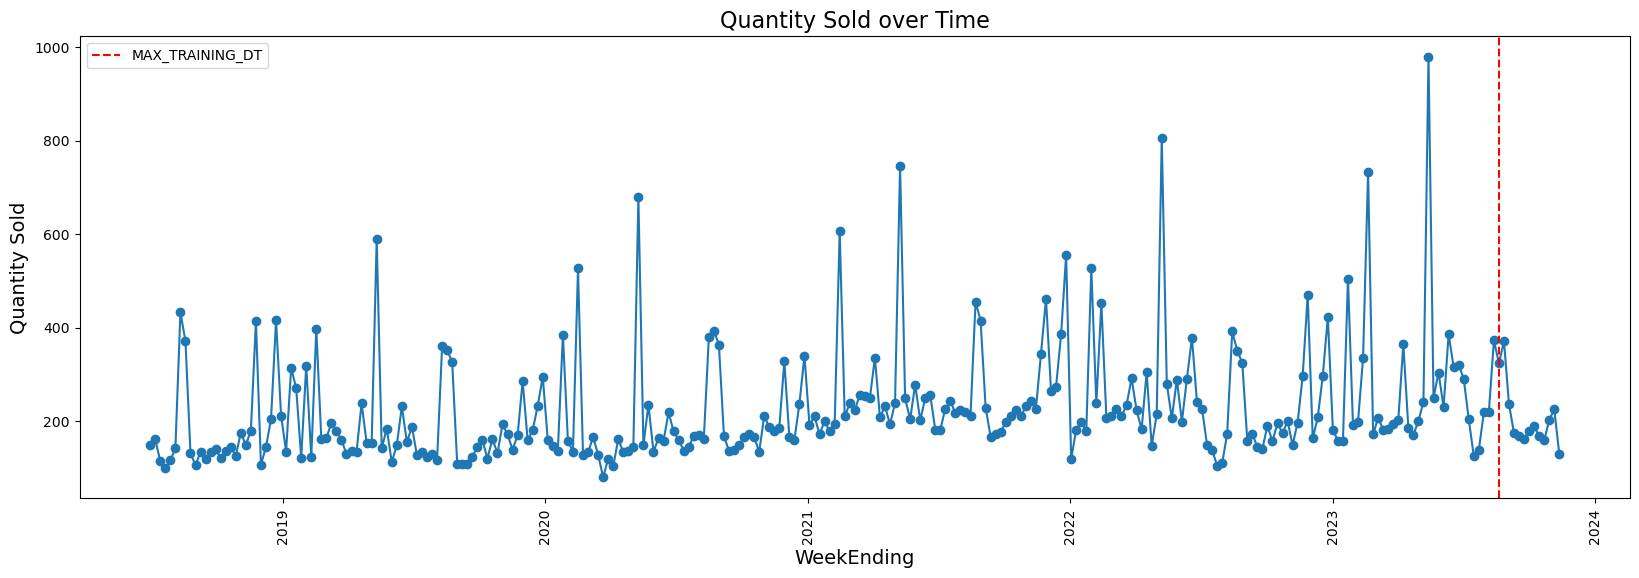

AutoCorrelations


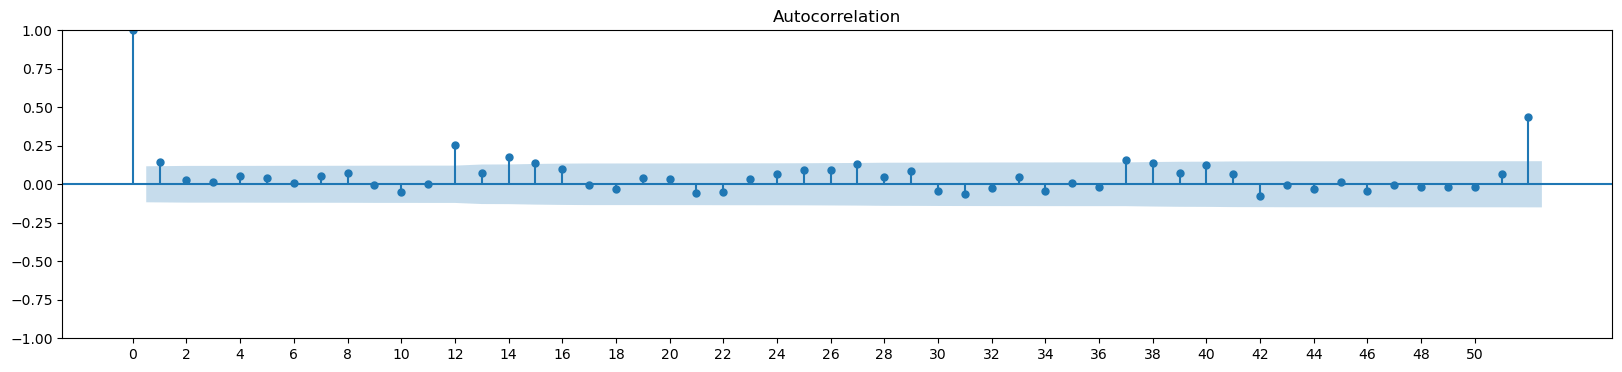

Understanding if the diff is stationaty


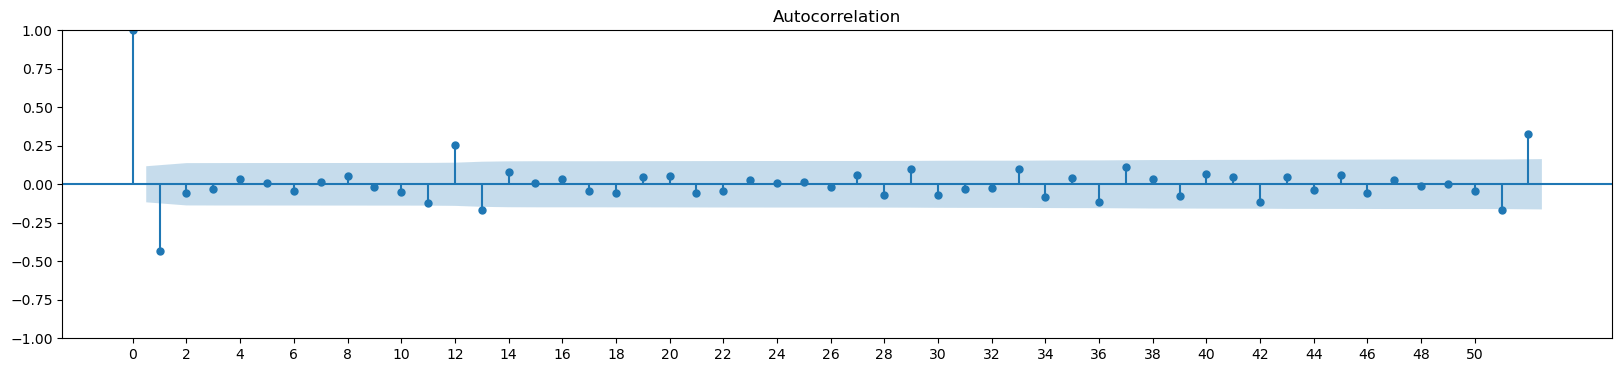

Selected Order (p, d, q): (1, 1, 4)
Selected Seasonal Order (P, D, Q, s): (1, 1, 0, 52)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  268
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 52)   Log Likelihood               -1211.713
Date:                             Tue, 14 Nov 2023   AIC                           2465.425
Time:                                     19:49:18   BIC                           2536.209
Sample:                                 07-01-2018   HQIC                          2494.025
                                      - 08-13-2023                                         
Covariance Type:                               opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

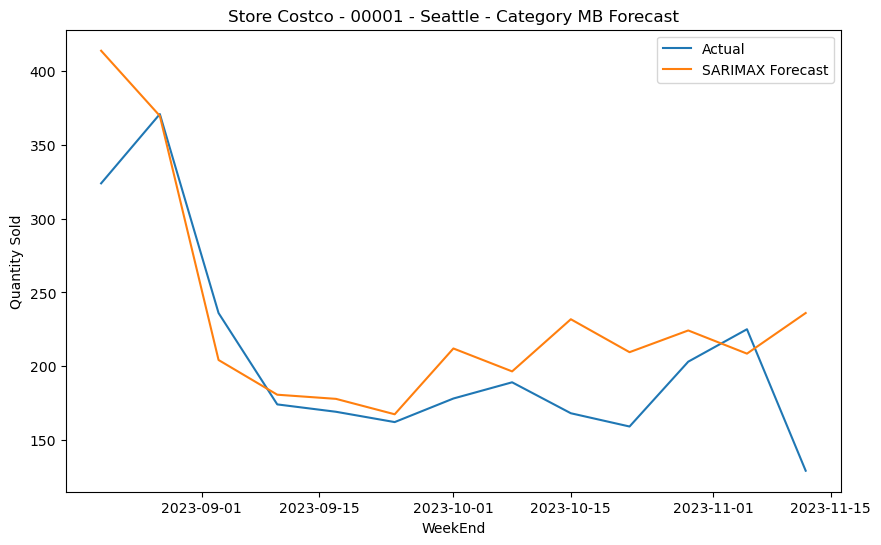

Training Set


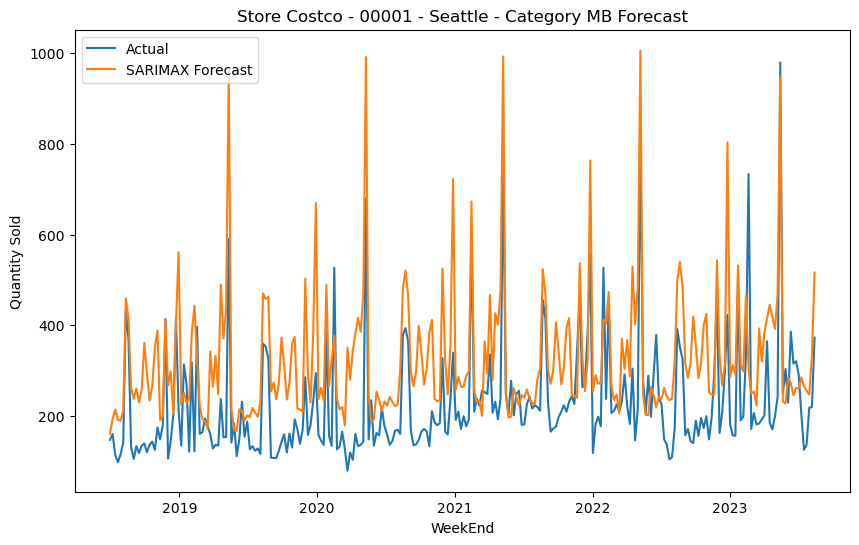

-----------------------------PROPHET RESULTS--------------------------------------


19:49:18 - cmdstanpy - INFO - Chain [1] start processing
19:49:19 - cmdstanpy - INFO - Chain [1] done processing


Store Costco - 00001 - Seattle - Category RB Forecast


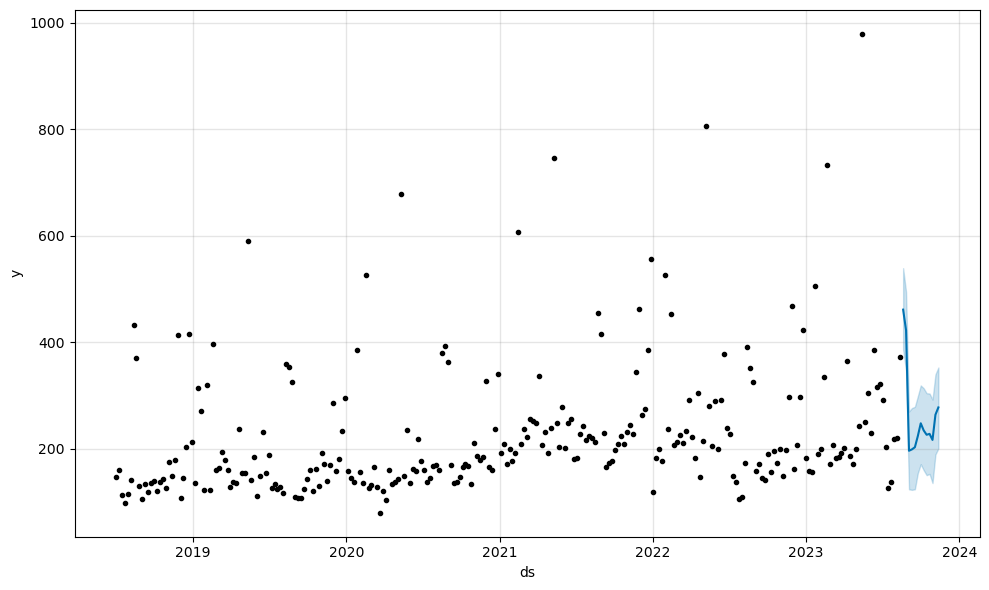

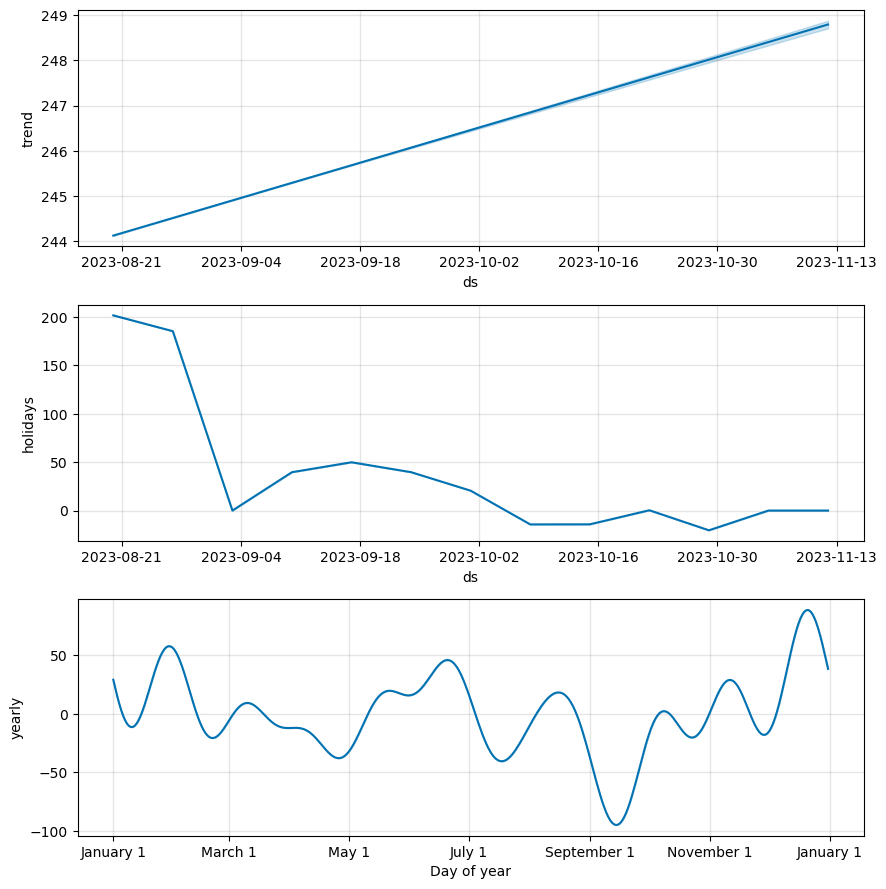

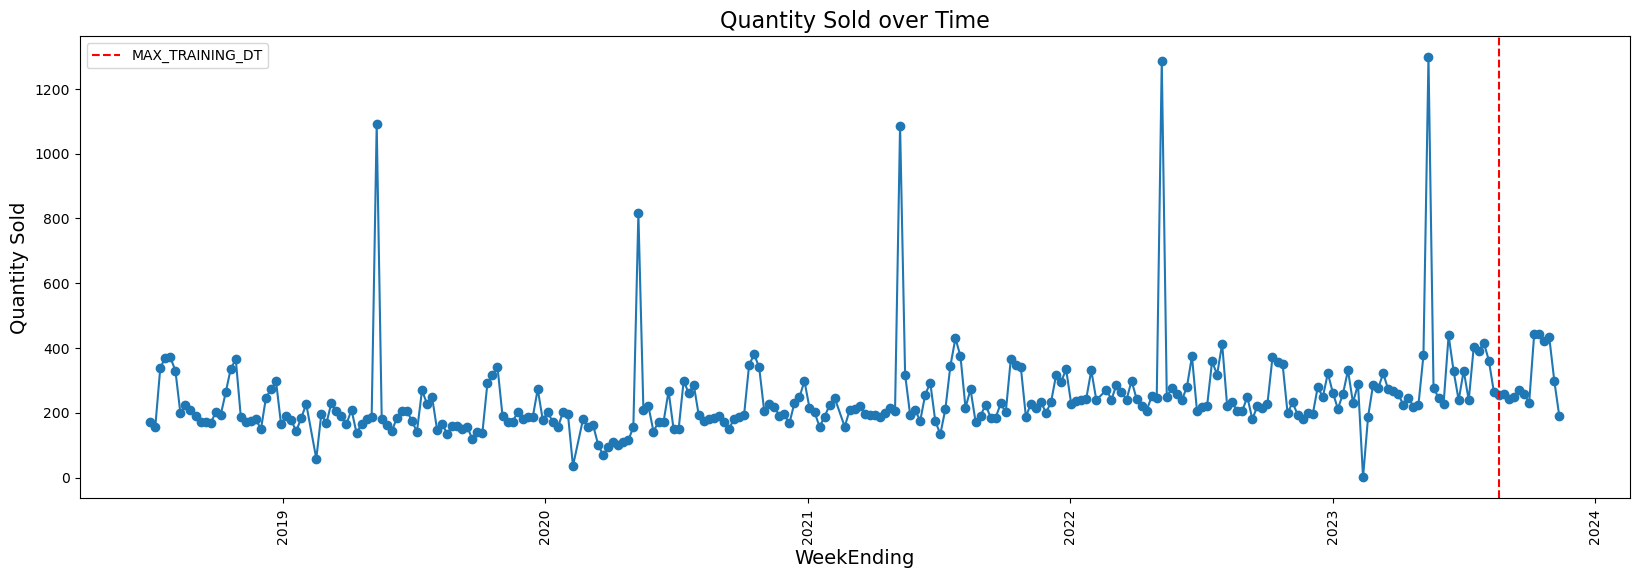

AutoCorrelations


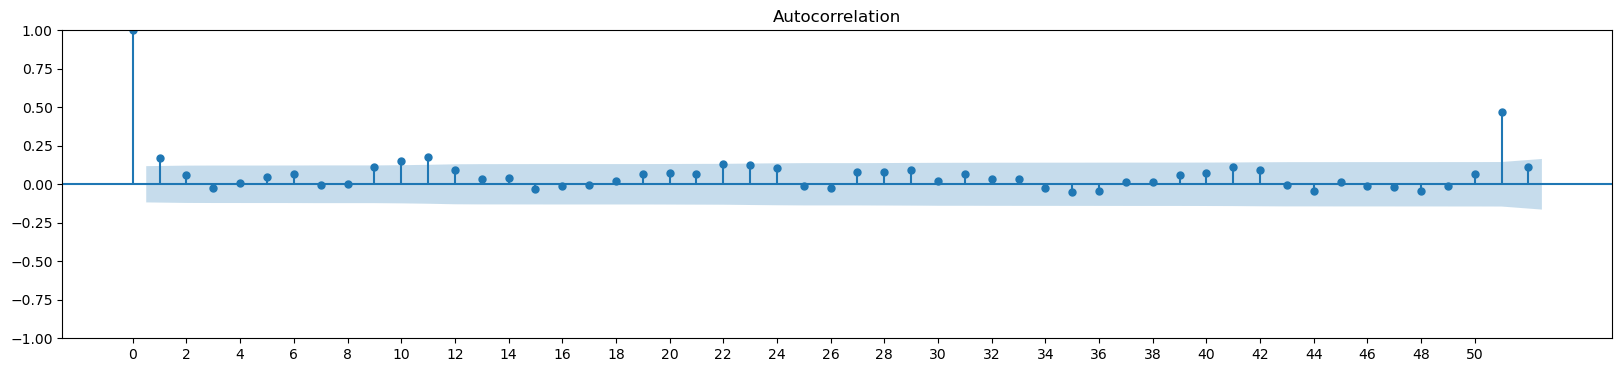

Understanding if the diff is stationaty


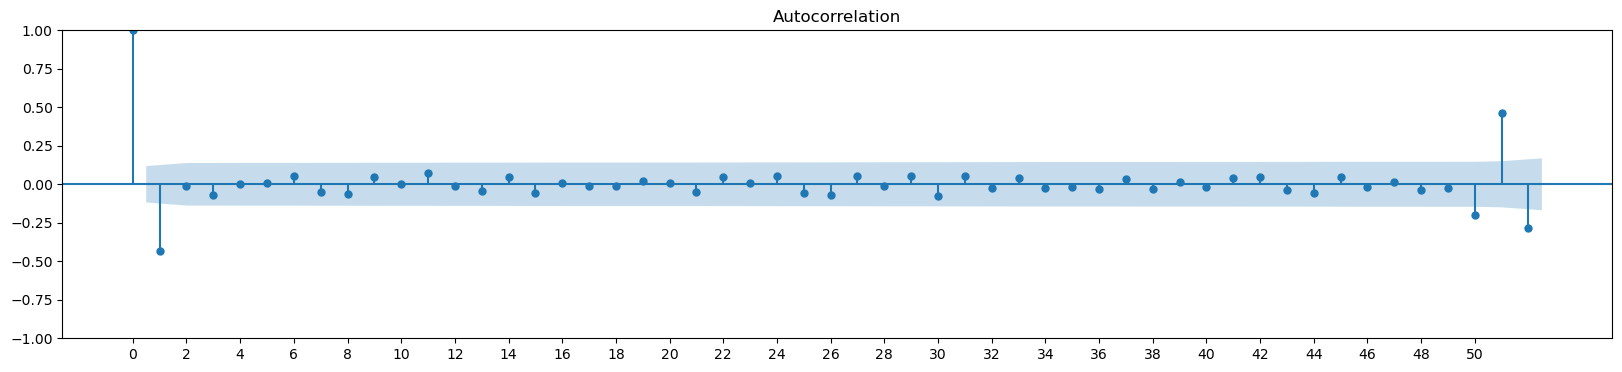

Selected Order (p, d, q): (1, 1, 4)
Selected Seasonal Order (P, D, Q, s): (1, 1, 0, 52)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  264
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 52)   Log Likelihood               -1147.788
Date:                             Tue, 14 Nov 2023   AIC                           2337.576
Time:                                     19:49:56   BIC                           2407.965
Sample:                                          0   HQIC                          2366.029
                                             - 264                                         
Covariance Type:                               opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

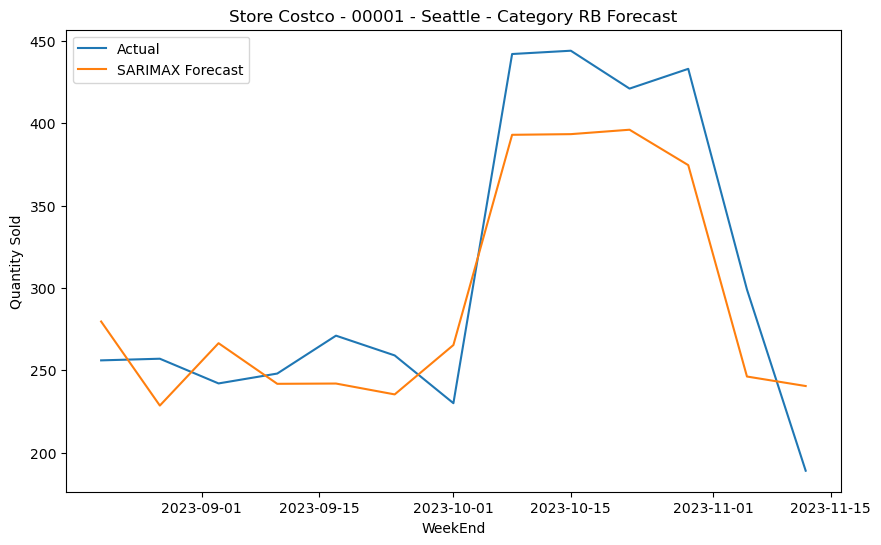

Training Set


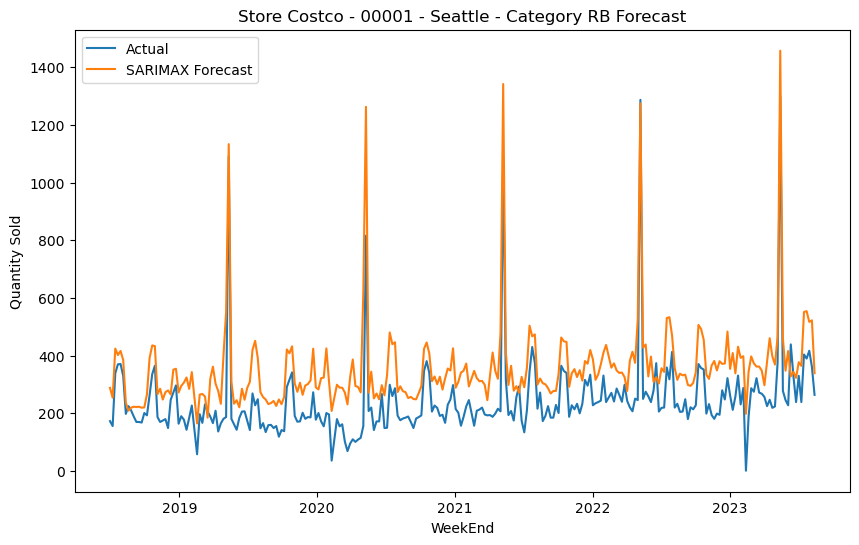

-----------------------------PROPHET RESULTS--------------------------------------


19:49:57 - cmdstanpy - INFO - Chain [1] start processing
19:49:57 - cmdstanpy - INFO - Chain [1] done processing


Store Costco - 00747 - Woodinville - Category GB Forecast


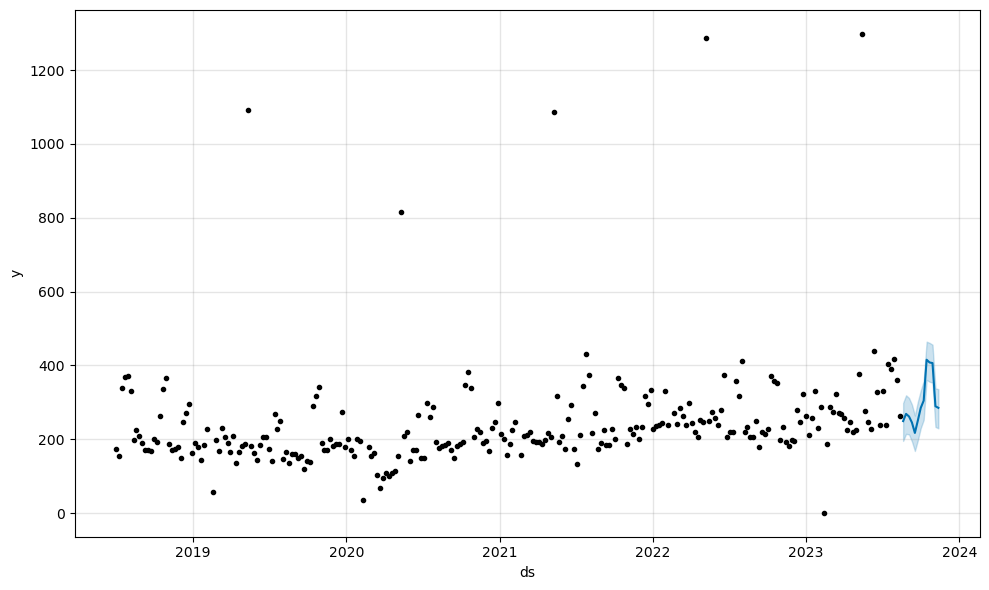

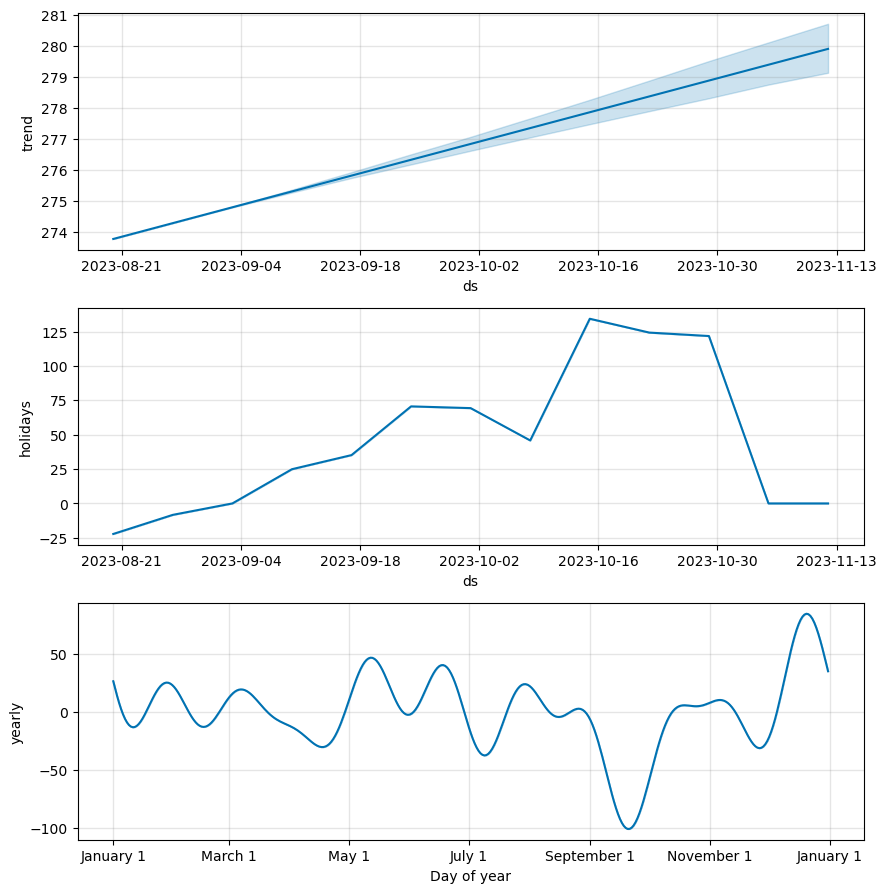

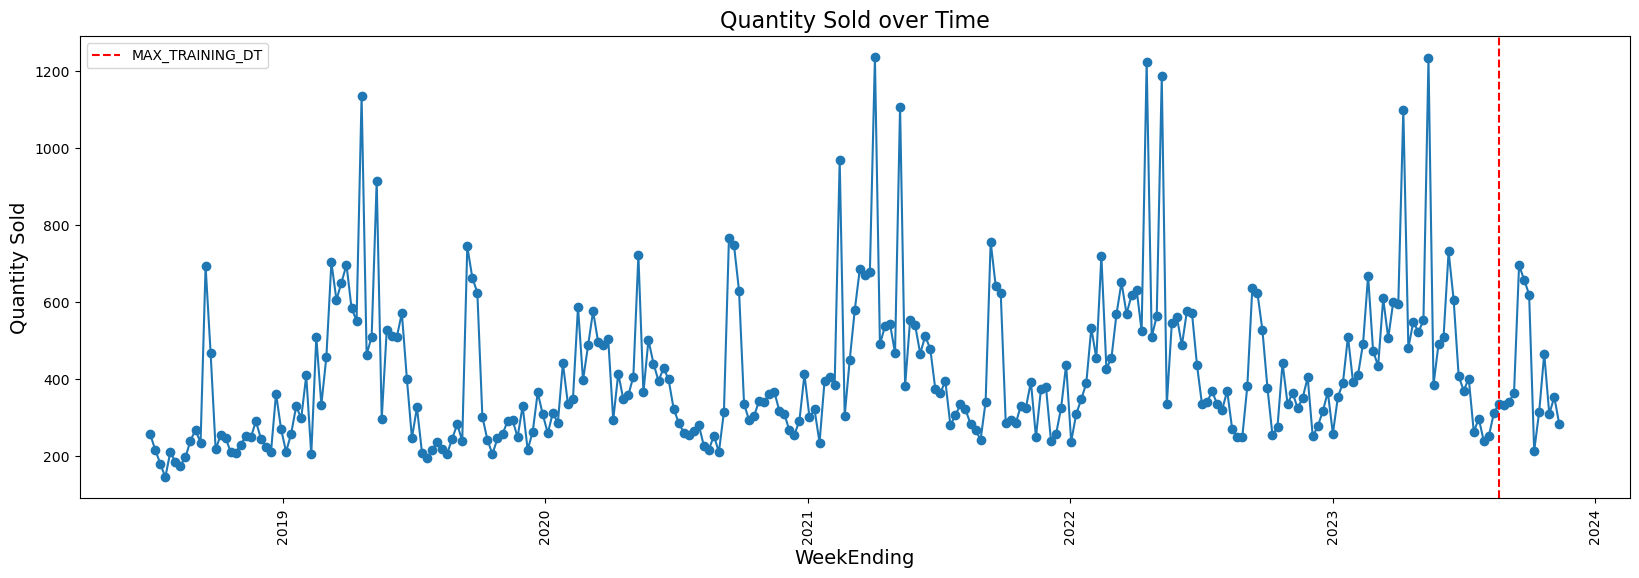

AutoCorrelations


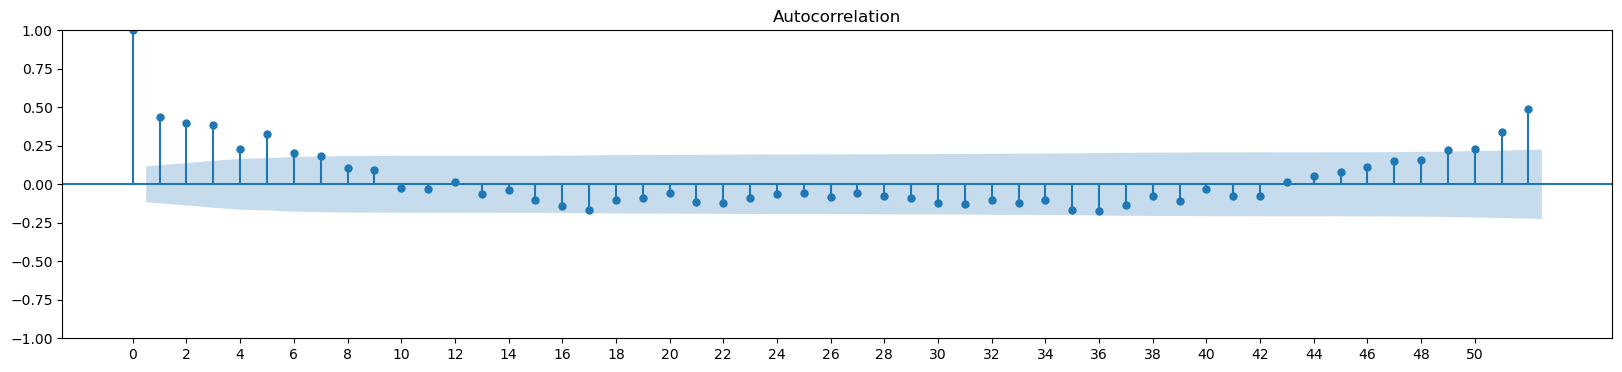

Understanding if the diff is stationaty


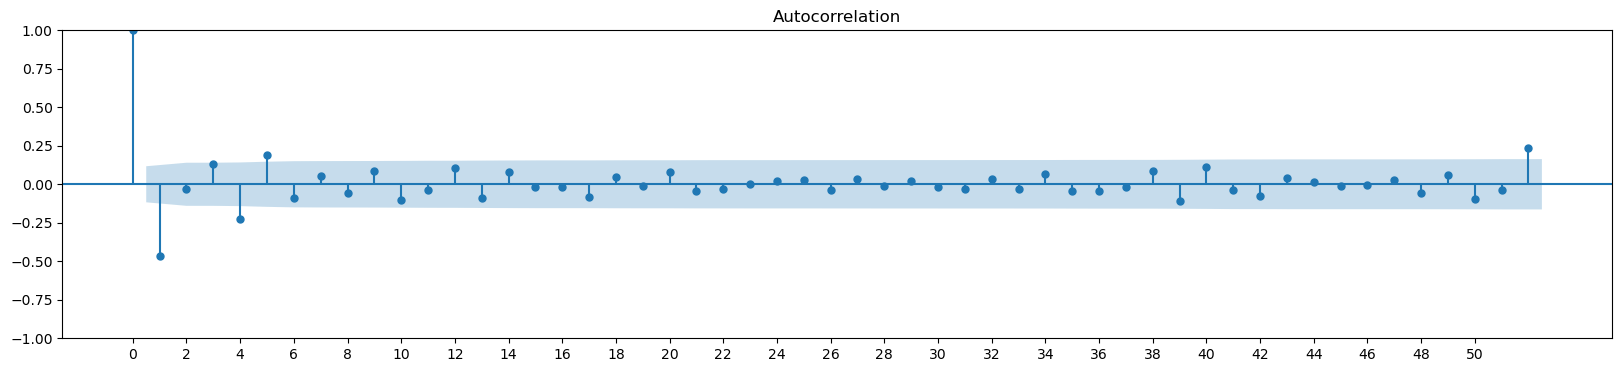

Selected Order (p, d, q): (1, 1, 4)
Selected Seasonal Order (P, D, Q, s): (1, 1, 0, 52)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  268
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 52)   Log Likelihood               -1264.813
Date:                             Tue, 14 Nov 2023   AIC                           2571.626
Time:                                     19:50:35   BIC                           2642.409
Sample:                                 07-01-2018   HQIC                          2600.225
                                      - 08-13-2023                                         
Covariance Type:                               opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

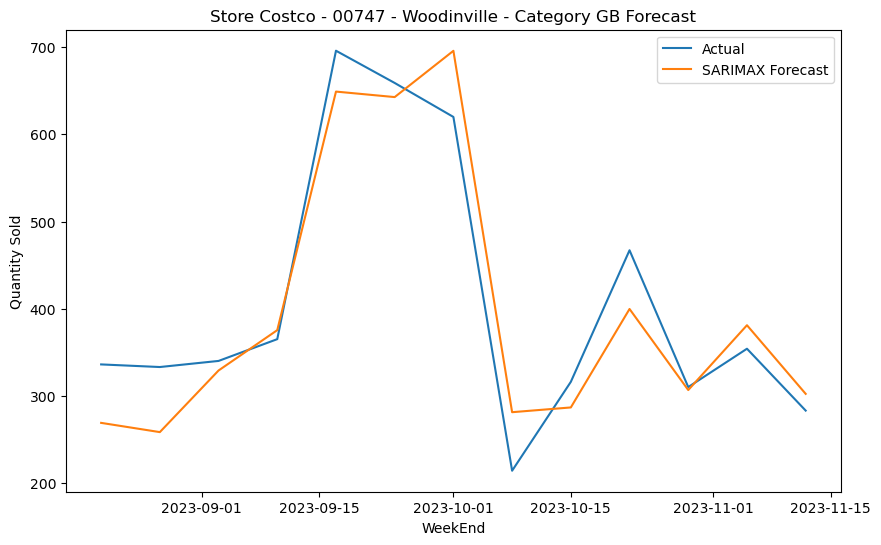

Training Set


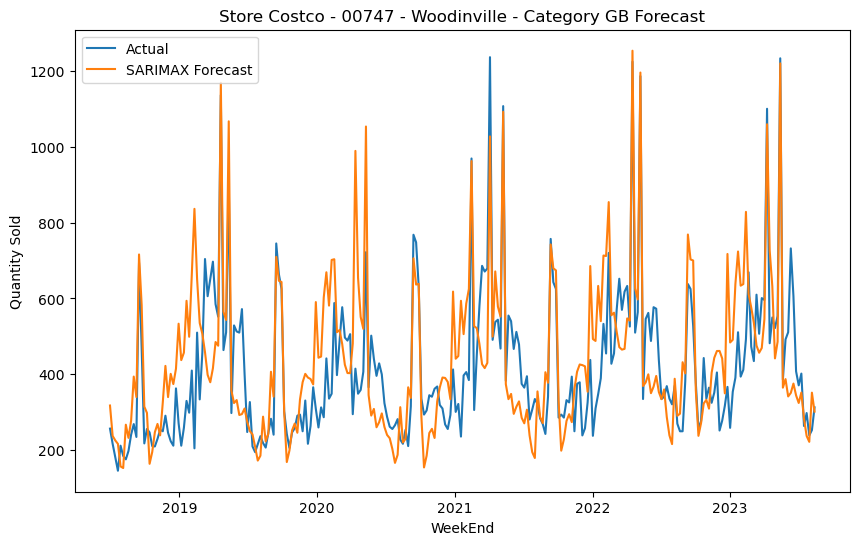

-----------------------------PROPHET RESULTS--------------------------------------


19:50:36 - cmdstanpy - INFO - Chain [1] start processing
19:50:36 - cmdstanpy - INFO - Chain [1] done processing


Store Costco - 00747 - Woodinville - Category MB Forecast


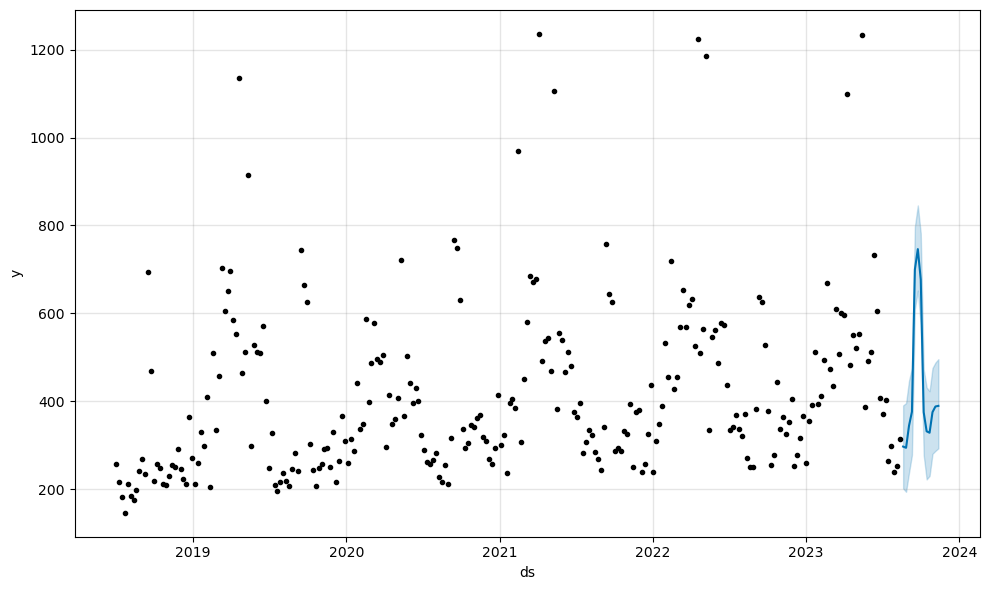

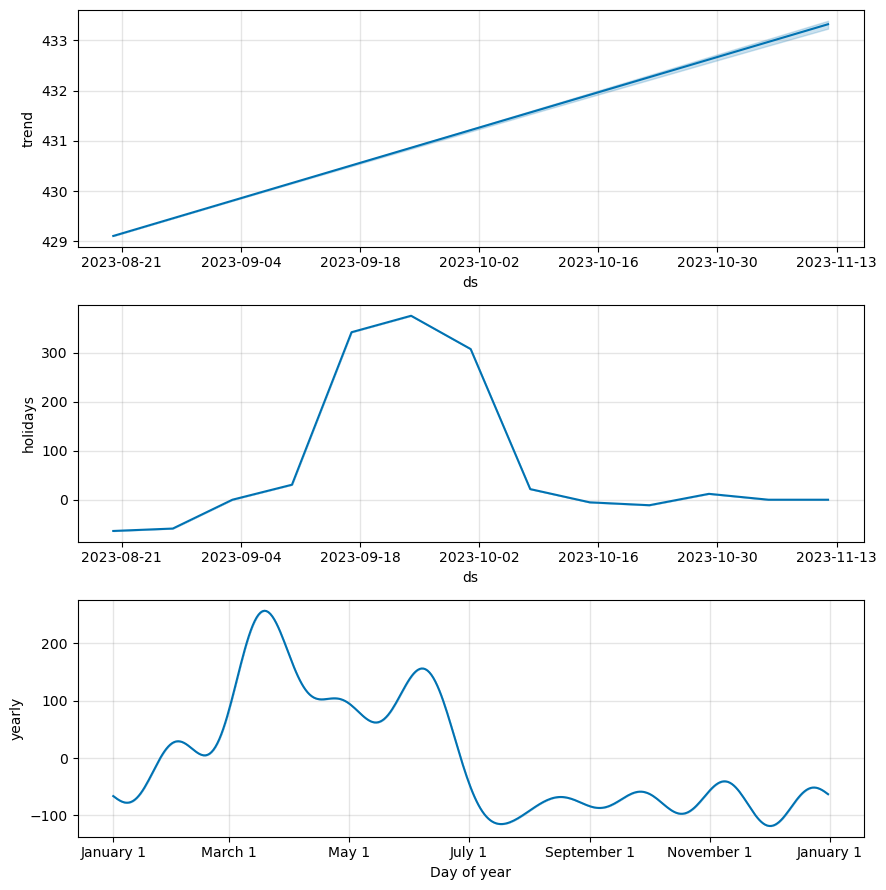

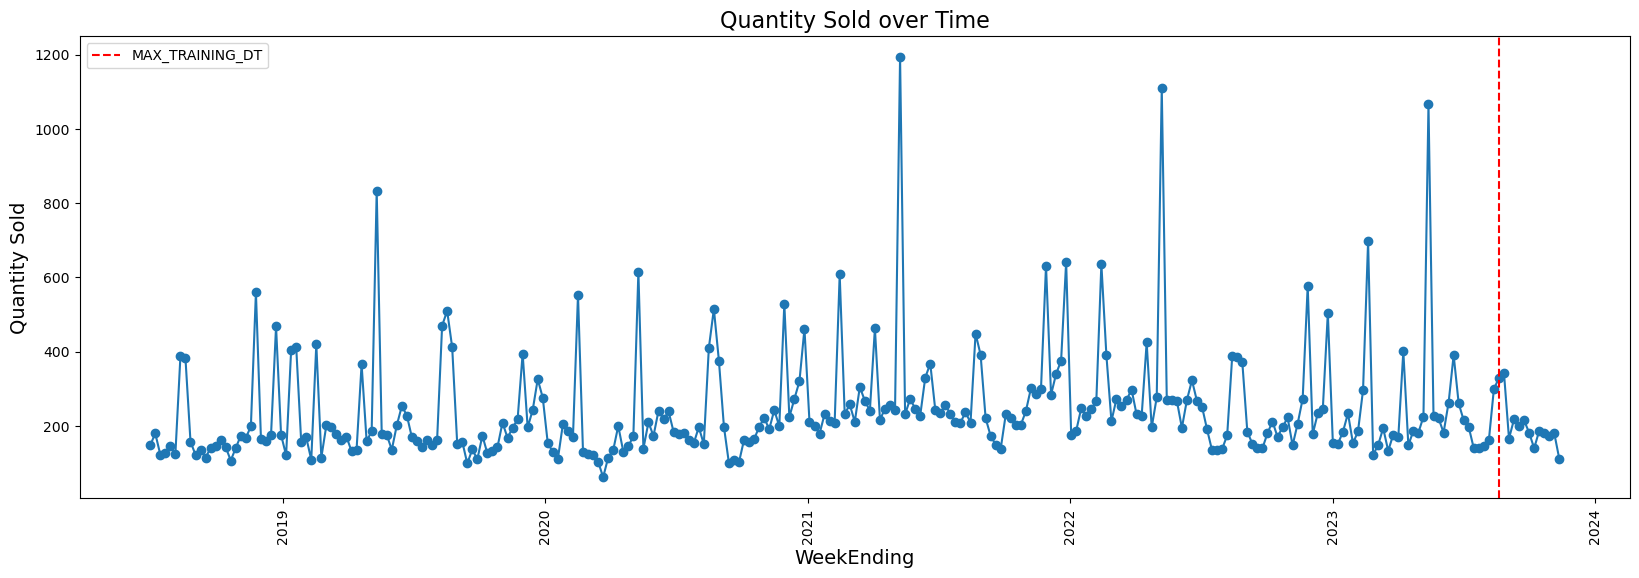

AutoCorrelations


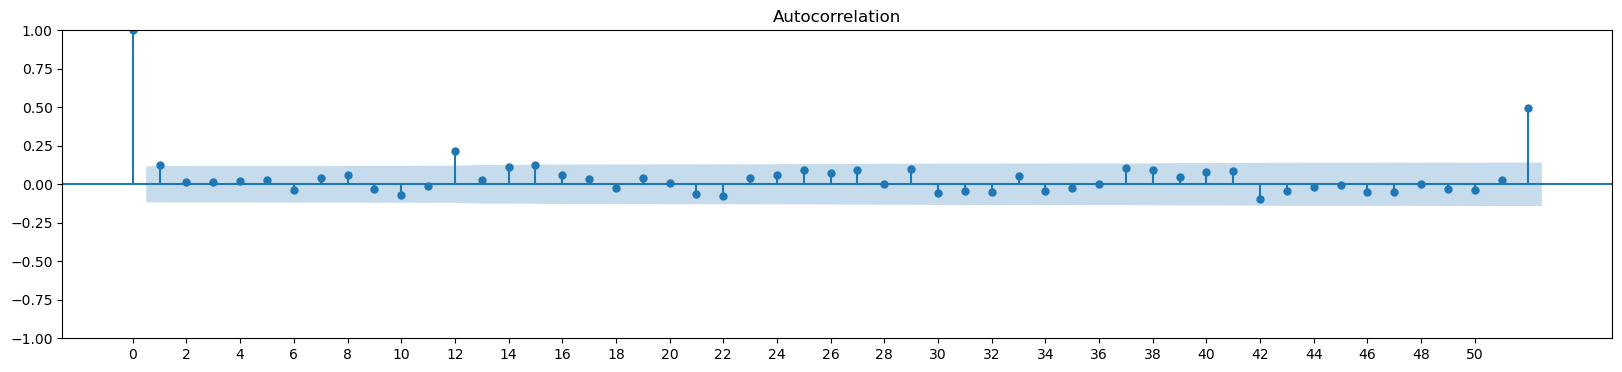

Understanding if the diff is stationaty


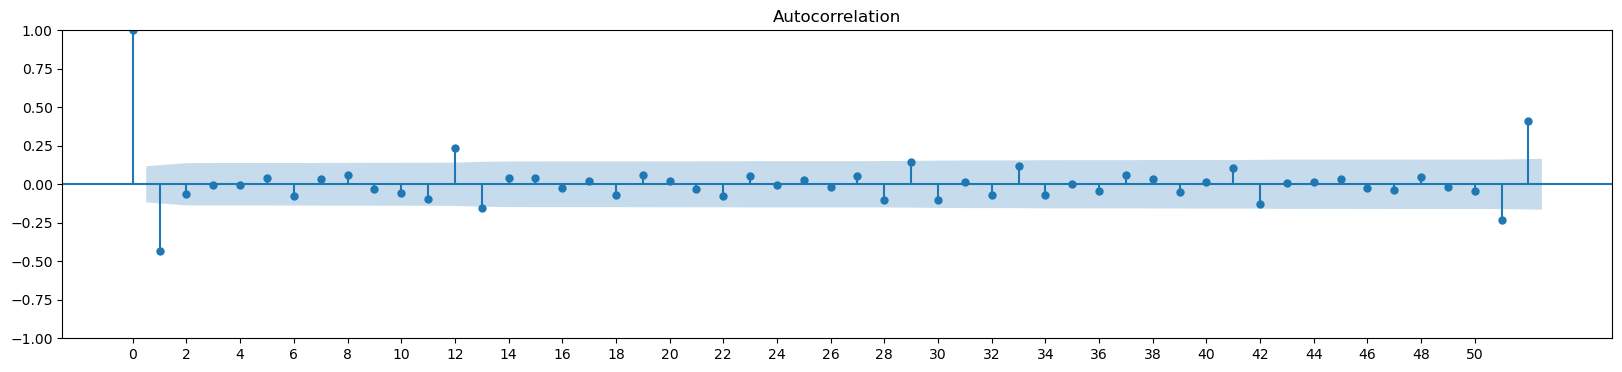

Selected Order (p, d, q): (1, 1, 4)
Selected Seasonal Order (P, D, Q, s): (1, 1, 0, 52)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  268
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 52)   Log Likelihood               -1231.149
Date:                             Tue, 14 Nov 2023   AIC                           2504.297
Time:                                     19:51:15   BIC                           2575.081
Sample:                                 07-01-2018   HQIC                          2532.897
                                      - 08-13-2023                                         
Covariance Type:                               opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

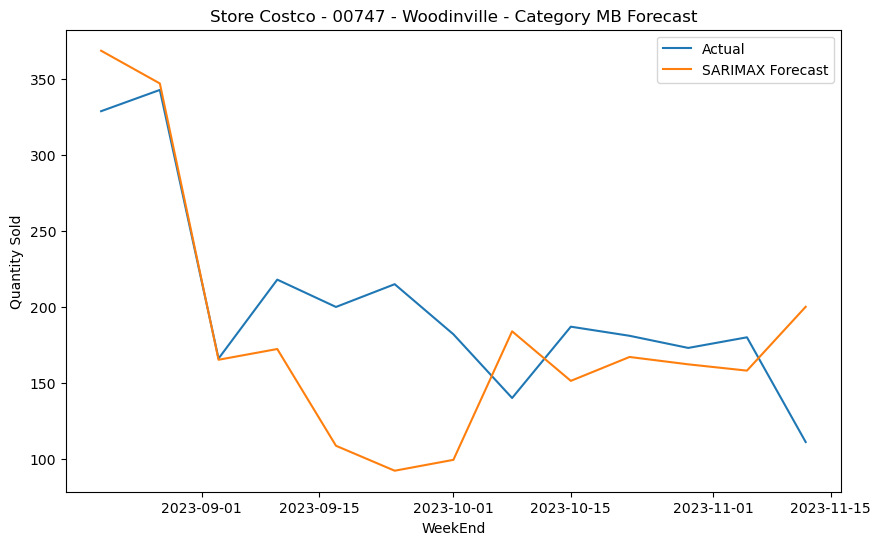

Training Set


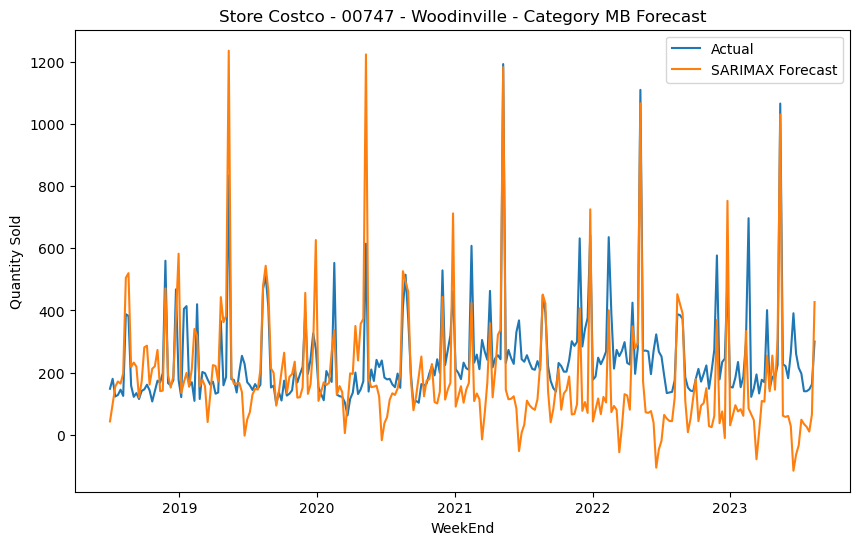

-----------------------------PROPHET RESULTS--------------------------------------


19:51:16 - cmdstanpy - INFO - Chain [1] start processing
19:51:16 - cmdstanpy - INFO - Chain [1] done processing


Store Costco - 00747 - Woodinville - Category RB Forecast


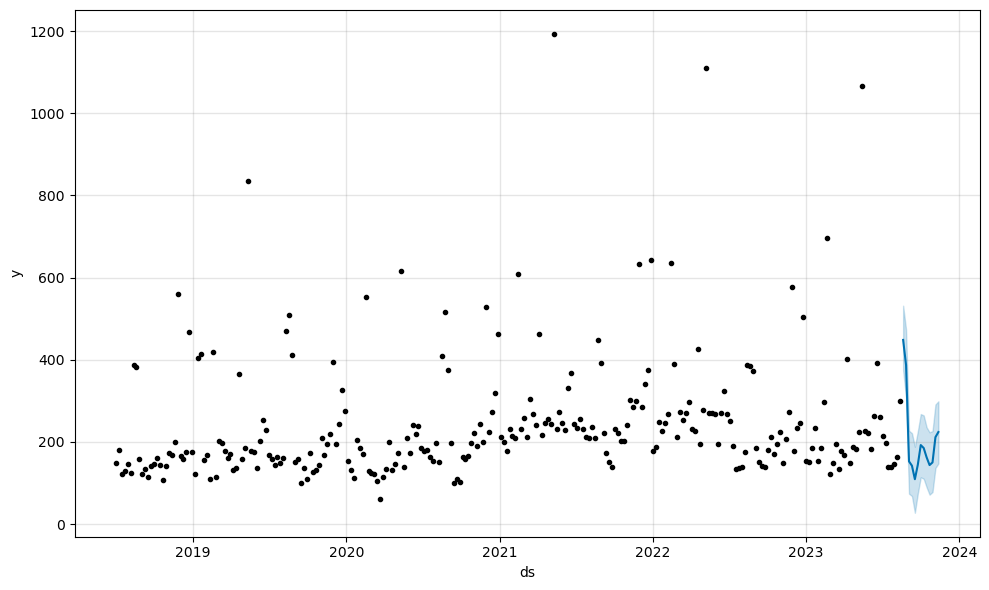

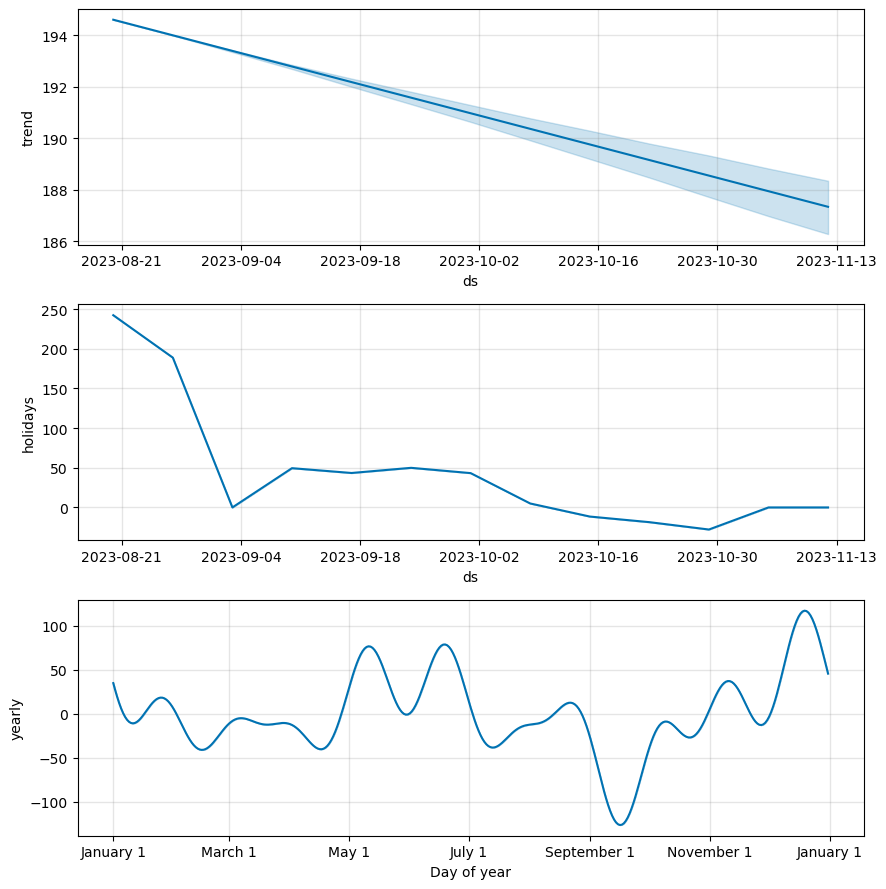

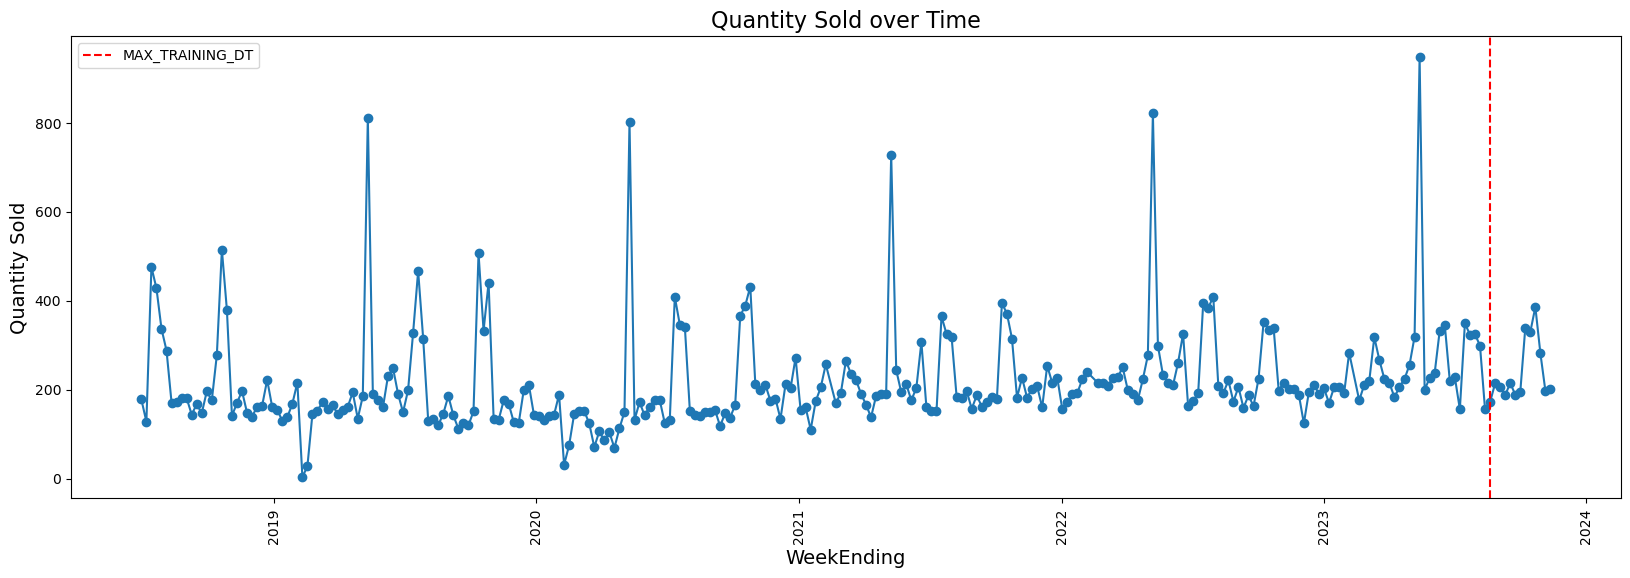

AutoCorrelations


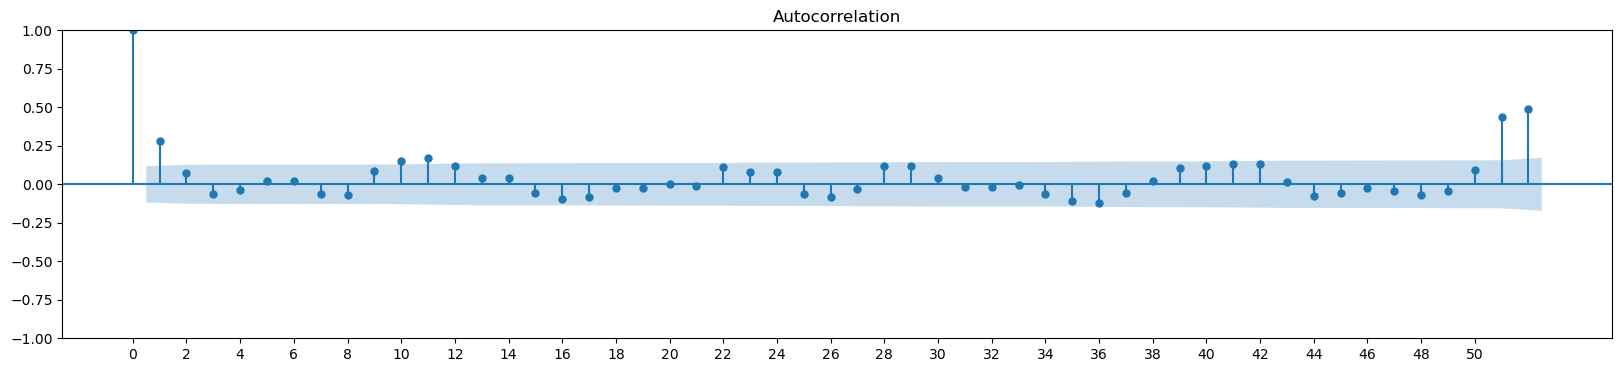

Understanding if the diff is stationaty


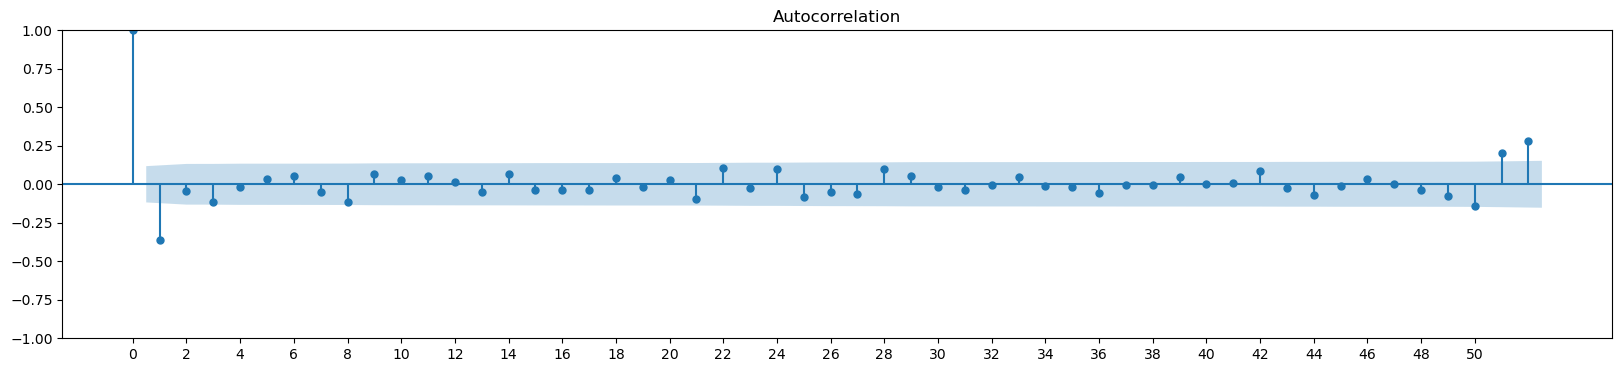

Selected Order (p, d, q): (1, 1, 4)
Selected Seasonal Order (P, D, Q, s): (1, 1, 0, 52)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  265
Model:             SARIMAX(1, 1, 4)x(1, 1, [], 52)   Log Likelihood               -1131.535
Date:                             Tue, 14 Nov 2023   AIC                           2305.070
Time:                                     19:51:56   BIC                           2375.559
Sample:                                          0   HQIC                          2333.560
                                             - 265                                         
Covariance Type:                               opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

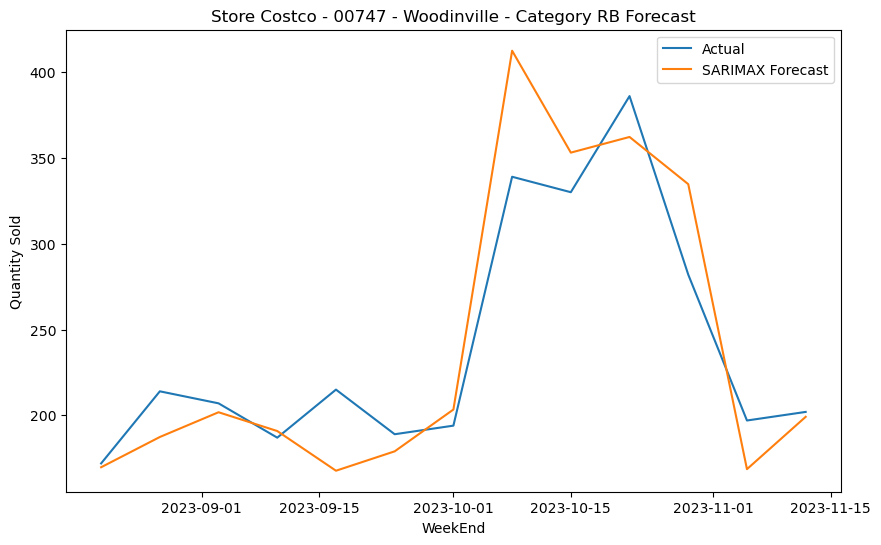

Training Set


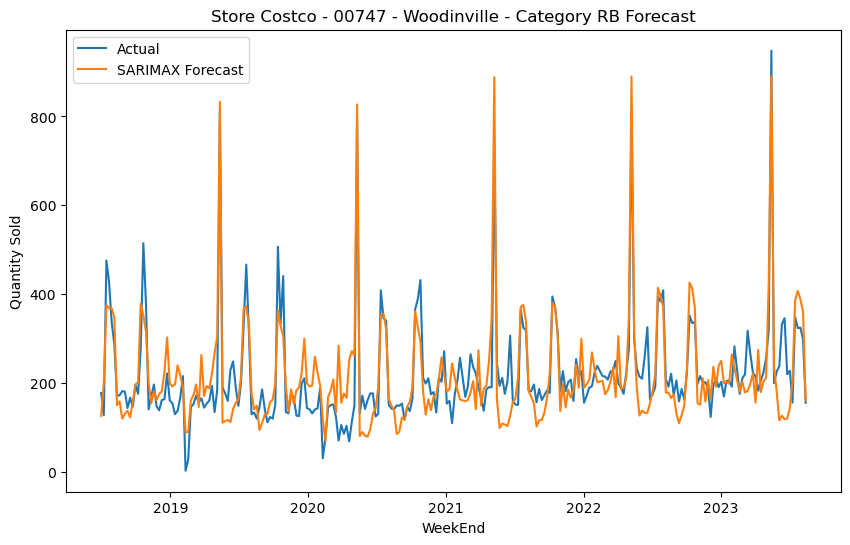

-----------------------------PROPHET RESULTS--------------------------------------


19:51:57 - cmdstanpy - INFO - Chain [1] start processing
19:51:57 - cmdstanpy - INFO - Chain [1] done processing


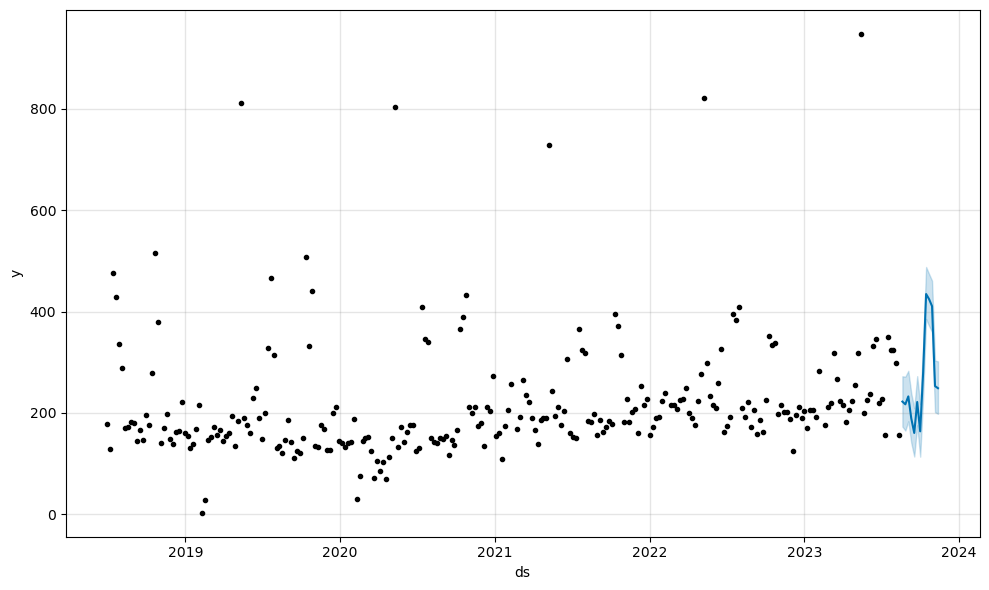

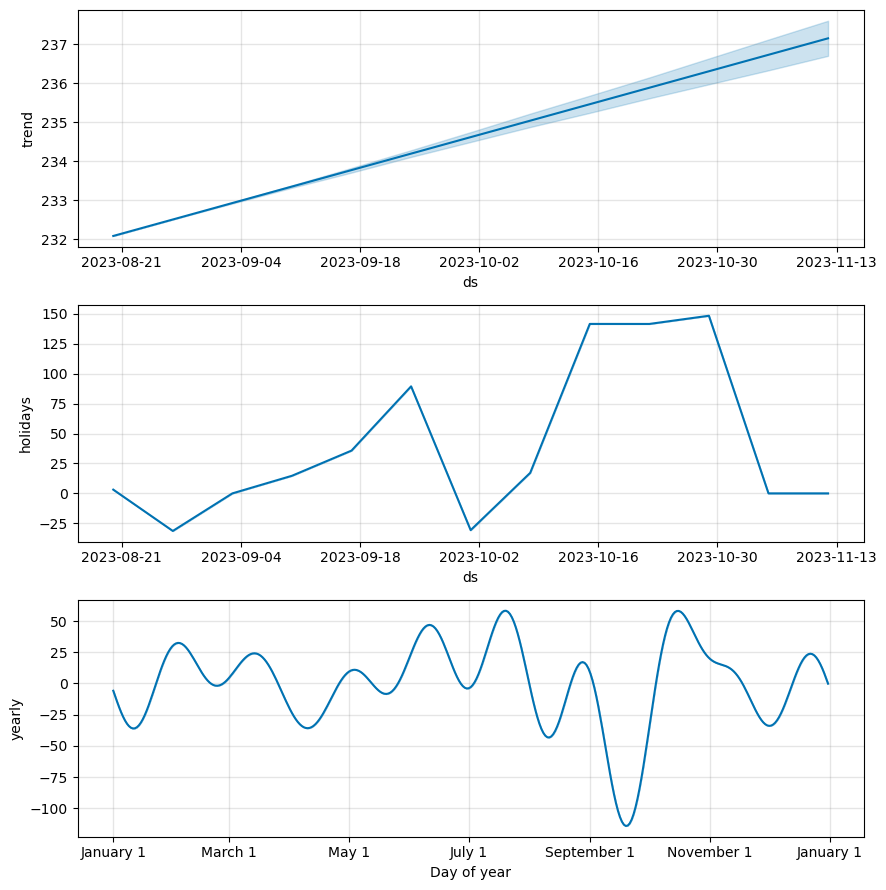

In [141]:
# Loop over df_mode per store/category and train models...
 
stores = df_model['Store'].unique()  # Extract unique store values
categories = df_model['CategoryItemCode'].unique()  # Extract unique category values

all_data = []

for store in stores:
    for category in categories:
        
        df_model_store = df_model[(df_model['Store'] == store) & (df_model['CategoryItemCode'] == category)]
        df_model_store=df_model_store.drop(['Facility','Store','CategoryItemCode'], axis=1)
        df_model_store = df_model_store.sort_values(by='WeekEnd')
        df_model_store.set_index('WeekEnd', inplace=True)
       
                
        # This will work to correct NAN when fillna is removed. 
        df_model_store['GasValue']=df_model_store['GasValue'].interpolate(method='linear')
        df_model_store['RoundedRetailPrice']= df_model_store['RoundedRetailPrice'].interpolate(method='linear')        
    
        df_model_store_train=df_model_store.loc[df_model_store.index < MAX_TRAINING_DT]
        df_model_store_test=df_model_store.loc[df_model_store.index >= MAX_TRAINING_DT]
        
                
        if len(df_model_store) < 30:
            # If fewer than 30 observations, skip this store-category combination
            print(f"Skipping Store {store} - Category {category}: Insufficient data for modeling" ,len(y))
            continue    
        
        print(f'Store {store} - Category {category} Forecast')
        
        
        # Plotting Sales over time
        plt.figure(figsize=(20, 6))
        plt.plot(df_model_store.index, df_model_store['QuantitySold'], marker='o', linestyle='-')
        plt.axvline(MAX_TRAINING_DT, color='red', linestyle='--', label='MAX_TRAINING_DT')
        plt.xlabel('WeekEnding', fontsize=14)
        plt.ylabel('Quantity Sold', fontsize=14)
        plt.title('Quantity Sold over Time', fontsize=16)
        plt.xticks(rotation='vertical')
        plt.legend()
        plt.show()
        
        
        
        print('AutoCorrelations')
       
        fig, ax= plt.subplots(figsize=(20,4))
        tsaplots.plot_acf(df_model_store['QuantitySold'], lags=52, ax=ax)
        plt.xticks(ticks=range(0,52,2))
        plt.show()
    
        
        print('Understanding if the diff is stationaty')
        
        fig, ax= plt.subplots(figsize=(20,4))
        tsaplots.plot_acf( df_model_store['QuantitySold'].diff().dropna(), lags=52, ax=ax)
        plt.xticks(ticks=range(0,52,2))
        plt.show()
        
            
        
        # Example structure using SARIMAX for demonstration
        X_train= df_model_store_train.drop(['QuantitySold'], axis=1)
        X_test = df_model_store_test.drop(['QuantitySold'], axis=1)
        y_train= df_model_store_train['QuantitySold']
        y_test = df_model_store_test['QuantitySold']
        
        y_train = np.asarray(y_train)
        X_train_df=X_train
        #X_train = np.asarray(X_train)
        
        y_test = np.asarray(y_test)
        X_test_df=X_test
        #X_test = np.asarray(X_test)
      
       
        # Define SARIMAX model
        order = (1, 1, 4)  # Example order of the ARIMA model - you can adjust this based on your data
        seasonal_order = (1, 1, 0, 52)  # Example seasonal order
        trend=(0,0)
        #order = auto_arima(y_train, exogenous=X_train, seasonal=True, suppress_warnings=True).order
        #seasonal_order = auto_arima(y_train, exogenous=X_train, seasonal=True, suppress_warnings=True).seasonal_order
        print("Selected Order (p, d, q):", order)
        print("Selected Seasonal Order (P, D, Q, s):", seasonal_order)
        
        # Is this a good idea? how to work with pipelines with SARIMAX
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        
        sarimax_model = SARIMAX(endog=y_train, exog= X_train , order=order, trend=trend, seasonal_order=seasonal_order)
        
        
     
        # Fit SARIMAX model
        sarimax_fit = sarimax_model.fit()
        # Access the estimated coefficients of all parameters, including exogenous variables
        print(sarimax_fit.summary())
        
        # Forecast using SARIMAX
        store_category_forecast = sarimax_fit.get_forecast(steps=len(y_test), exog=X_test)
        predicted_values = store_category_forecast.predicted_mean
        
        store_category_train_forecast = sarimax_fit.get_forecast(steps=len(y_train), exog=X_train)
        predicted_values_train = store_category_train_forecast.predicted_mean
        
        mse_sarimax = mean_squared_error(y_test, predicted_values)
        print(f'Mean Squared Error: {mse_sarimax}')
        
        shrink_sarimax = 1-y_test / predicted_values
        
       
        
        print('Forecast')
        # Visualize the forecasted values
        plt.figure(figsize=(10, 6))
        plt.plot(df_model_store_test.index, y_test, label='Actual')
        plt.plot(df_model_store_test.index, predicted_values, label='SARIMAX Forecast')
        plt.title(f'Store {store} - Category {category} Forecast')
        plt.xlabel('WeekEnd')  # Add x-axis label
        plt.ylabel('Quantity Sold')  # Add y-axis label
        plt.legend()
        plt.show()
        
        print('Training Set')
        # Visualize the forecasted values
        plt.figure(figsize=(10, 6))
        plt.plot(df_model_store_train.index, y_train, label='Actual')
        plt.plot(df_model_store_train.index, predicted_values_train, label='SARIMAX Forecast')
        plt.title(f'Store {store} - Category {category} Forecast')
        plt.xlabel('WeekEnd')  # Add x-axis label
        plt.ylabel('Quantity Sold')  # Add y-axis label
        plt.legend()
        plt.show()

        # Modeling Profet
        print('-----------------------------PROPHET RESULTS--------------------------------------')
        
        prophet_model = Prophet(holidays =  df_prophet_holidays)
        prophet_model.add_country_holidays(country_name='US')

        df_prophet = pd.DataFrame({'ds': df_model_store_train.index, 'y': y_train})
        prophet_model.fit(df_prophet)
        # Creates a DF with dates to project into the future. the periods are given in days.
        future_prophet = pd.DataFrame(df_model_store_test.index).rename(columns={'WeekEnd': 'ds'}) #prophet_model.make_future_dataframe(periods=len(y_test)*7)
        forecast_prophet = prophet_model.predict(future_prophet)
        
        shrink_prophet = 1-y_test / forecast_prophet['yhat'].tolist()
        
        
        fig1 = prophet_model.plot(forecast_prophet)
        fig2 = prophet_model.plot_components(forecast_prophet)
        
      
        #predicted_values_prophet = forecast[['yhat']]
        #mse_prophet = mean_squared_error(y_test, predicted_values_prophet)
        store_category_data = {
            'store': store,
            'category': category,
            'week_ending_sarimax': df_model_store_test.index.tolist(),
            'week_ending_prohet':future_prophet['ds'].tolist(),
            'y_test': y_test.tolist(),
            'mse_sarimax': mse_sarimax,
            #'mse_prophet': mse_sprophet,
            'predicted_values_sarimax': predicted_values.tolist(),
            'predicted_values_prophet': forecast_prophet['yhat'].tolist(),
            'predicted_values_prophet_lower': forecast_prophet['yhat_lower'].tolist(),
            'predicted_values_prophet_ trend': forecast_prophet['trend'].tolist(),
            'shrink_sarimax': shrink_sarimax.tolist(),
            'shrink_profet': shrink_prophet.tolist()
            }
        all_data.append(store_category_data)
 

In [142]:
all_data
#forecast_prophet  trend	yhat_lower	yhat_upper	trend_lower	trend_upper

[{'store': 'Costco - 00001 - Seattle',
  'category': 'GB',
  'week_ending_sarimax': [Timestamp('2023-08-20 00:00:00'),
   Timestamp('2023-08-27 00:00:00'),
   Timestamp('2023-09-03 00:00:00'),
   Timestamp('2023-09-10 00:00:00'),
   Timestamp('2023-09-17 00:00:00'),
   Timestamp('2023-09-24 00:00:00'),
   Timestamp('2023-10-01 00:00:00'),
   Timestamp('2023-10-08 00:00:00'),
   Timestamp('2023-10-15 00:00:00'),
   Timestamp('2023-10-22 00:00:00'),
   Timestamp('2023-10-29 00:00:00'),
   Timestamp('2023-11-05 00:00:00'),
   Timestamp('2023-11-12 00:00:00')],
  'week_ending_prohet': [Timestamp('2023-08-20 00:00:00'),
   Timestamp('2023-08-27 00:00:00'),
   Timestamp('2023-09-03 00:00:00'),
   Timestamp('2023-09-10 00:00:00'),
   Timestamp('2023-09-17 00:00:00'),
   Timestamp('2023-09-24 00:00:00'),
   Timestamp('2023-10-01 00:00:00'),
   Timestamp('2023-10-08 00:00:00'),
   Timestamp('2023-10-15 00:00:00'),
   Timestamp('2023-10-22 00:00:00'),
   Timestamp('2023-10-29 00:00:00'),
   Time


<p> Work on defining how to project gas forward? 2 week trend? use current price? </p>

In [ ]:
merged_df['GasValueTrend']=merged_df['GasValue']/merged_df['GasValue'].shift(1)

In [51]:
#Function to 'Step' randomly in hyperparameter space to build optimization for hyper parameters
x0={'p':1,'d':1,'q':0,'P':0,'D':0,'Q':0,'a0':1,'a1':0}

def step(params):
    updated_params=deepcopy(params)
    selected_variable=np.random.choice(['p','d','q','P','D','Q','a0','a1'], size=1)[0]
    current_value= updated_params[selected_variable]
    # Update the current value randomly
    updated_value = current_value + np.random.choice([-1,1],size=1)[0]
    # enforce parameters limits
    if(selected_variable in ['p','q']):
        low, high = 0,6
    else:
        
        low, high = 0,1
        
    updated_value = min([max([low,updated_value]),high])
    updated_params[selected_variable]= updated_value
    
    return   updated_params

step(x0)

{'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 0}